# Script limpio sin explicaciones

## Funciones

In [11]:
from crate import client
import pandas as pd
import matplotlib.pyplot as plt
import h2o

HOST_CRATE='localhost:4200'
HOST_H2O='localhost:54321'


#==============================================================================
#               F U N C T I O N S
#==============================================================================

def query_to_dataframe(crate_host, query, username="crate"):
    """
    Ejecuta una consulta en CrateDB y devuelve los resultados como un DataFrame de pandas.

    :param crate_host: Dirección del servidor CrateDB (por ejemplo, "http://localhost:4200/")
    :param query: Consulta SQL a ejecutar
    :param username: Usuario para la conexión (por defecto "crate")
    :return: pandas DataFrame con los resultados de la consulta
    """
    try:
        # Conexión a CrateDB
        connection = client.connect(crate_host, username=username)
        cursor = connection.cursor()

        # Ejecutar la consulta
        cursor.execute(query)

        # Obtener las columnas de la consulta
        columns = [col[0] for col in cursor.description]

        # Obtener los resultados de la consulta
        data = cursor.fetchall()

        # Convertir los resultados a un DataFrame de pandas
        df = pd.DataFrame(data, columns=columns)

        # Cerrar la conexión
        cursor.close()
        connection.close()

        return df

    except Exception as e:
        print("Error en la consulta:", e)
        return None

#==============================================================================

def plot_columns(df, groups):
    """
    Grafica las columnas especificadas de un DataFrame.

    Args:
    df (pd.DataFrame): DataFrame que contiene los datos.
    groups (list): Lista de índices de columnas que deseas graficar.

    Returns:
    None
    """
    values = df.values  # Asegúrate de que 'df' sea tu DataFrame

    plt.figure(figsize=(20,10))
    for i, group in enumerate(groups, start=1):
        plt.subplot(len(groups), 1, i)
        plt.plot(values[:, group])
        plt.title(df.columns[group], y=0.5, loc='right')

    plt.tight_layout()
    plt.show()

def resample_and_plot(df, resample_freq='D', rolling_window=720):
    """
    Resamplea una serie temporal y calcula la media deslizante, luego visualiza los datos.

    Args:
    df (pd.Series): Serie temporal con un índice de fecha y hora.
    resample_freq (str): Frecuencia de resampleo (por defecto 'D' para días).
    rolling_window (int): Tamaño de la ventana para la media deslizante (por defecto 720).

    Returns:
    None
    """
    # Resampleamos por la frecuencia especificada
    df_resample = df.resample(resample_freq).mean()
    print(f"Resample por {resample_freq}:\n", df_resample.head())

    # Calculamos la media deslizante
    df_roll = df.rolling(window=rolling_window).mean()
    print(f"Media Deslizante (ventana de {rolling_window}):\n", df_roll.head(10))

    # Visualizamos los datos resampleados con su media deslizante
    ax = df.plot(alpha=0.5, style='-', figsize=(15, 10))  # guardamos los ejes para reutilizarlos
    df_resample.plot(style=':', ax=ax, label=f'Resample {resample_freq}')
    df_roll.plot(style='--', ax=ax, label=f'Media deslizante (ventana de {rolling_window})')
    ax.legend()
    plt.show()
    return df_resample

def detrend_and_plot(df, rolling_window=24):
    """
    Elimina la tendencia de una serie temporal utilizando una media deslizante y visualiza los datos.

    Args:
    o3 (pd.Series): Serie temporal con un índice de fecha y hora.
    rolling_window (int): Tamaño de la ventana para la media deslizante (por defecto 24).

    Returns:
    None
    """
    # Calculamos la media deslizante
    df_roll = df.rolling(window=rolling_window).mean()

    # Eliminamos la tendencia de la serie
    df_detrended = df - df_roll

    # Dibujamos la serie sin tendencia
    df_detrended.plot(figsize=(15, 10), linewidth=1.5, fontsize=15, title='Detrended')
    plt.show()

    return df_detrended

from statsmodels.tsa.seasonal import seasonal_decompose
def decompose_and_plot(serie_temporal, freq='D', period=24):
    """
    Descompone una serie temporal en tendencia, estacionalidad y residuos, y visualiza los componentes.

    Args:
    serie_temporal (pd.Series): Serie temporal con un índice de fecha y hora.
    freq (str): Frecuencia de resampleo (por defecto 'D' para días).
    period (int): Período para la descomposición estacional (por defecto 24).

    Returns:
    dict: Diccionario con los componentes de la descomposición (tendencia, estacionalidad, residuos).
    """
    # Interpolación y ajuste de frecuencia
    x = serie_temporal.interpolate(method="linear", order=2)
    x.index = pd.to_datetime(x.index)
    x = x.astype(float)  # Asegurarse de que los datos sean de tipo float
    x = x.asfreq(freq)  # Ajustar la frecuencia a la especificada

    # Descomposición estacional
    decomposition = seasonal_decompose(x, period=period)
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Visualización de los componentes
    fig, axes = plt.subplots(4, 1, figsize=(20, 10))
    axes[0].plot(x, label='Original')
    axes[0].legend(loc='best')
    axes[1].plot(trend, label='Trend')
    axes[1].legend(loc='best')
    axes[2].plot(seasonal, label='Seasonality')
    axes[2].legend(loc='best')
    axes[3].scatter(residual.index, residual, label='Residuals', s=10)
    axes[3].axhline(0, color='red', linestyle='-', linewidth=1)  # Línea en cero
    axes[3].legend(loc='best')
    plt.tight_layout()
    plt.show()

    return {'trend': trend, 'seasonal': seasonal, 'residual': residual}

from statsmodels.tsa.stattools import adfuller
def ADF_test(timeseries, dataDesc):
    """
    Realiza la prueba de Dickey-Fuller Aumentada (ADF) para verificar la estacionariedad de una serie temporal.

    Parámetros:
    timeseries (pd.Series): Serie temporal a analizar.
    dataDesc (str): Descripción de la serie temporal.

    Imprime:
    - Estadístico de la prueba ADF.
    - Valor p de la prueba ADF.
    - Valores críticos para diferentes niveles de confianza.
    """
    print(' > ¿Es estacionaria la serie {}?'.format(dataDesc))
    dftest = adfuller(timeseries.dropna(), autolag='AIC')
    print('Estadístico = {:.3f}'.format(dftest[0]))
    print('P-value = {:.3f}'.format(dftest[1]))
    print('Valores críticos :')
    for k, v in dftest[4].items():
        print('\t{}: {} - La serie es {} estacionaria con una confianza de {}%'.format(k, v, 'no' if v<dftest[0] else '', 100-int(k[:-1])))

def test_stationarity(timeseries, title, window=24):
    """
    Representa los estadísticos para comprobar la estacionariedad de una serie temporal.

    Parámetros:
    timeseries (pd.Series): Serie temporal a analizar.
    title (str): Título del gráfico.
    window (int): Ventana para el cálculo de la media y desviación estándar deslizante. Por defecto es 24.

    Genera:
    - Un gráfico que muestra la serie temporal original, la media deslizante y la desviación estándar deslizante.
    """
    # Determinar los estadísticos
    rolmean = pd.Series(timeseries).rolling(window=window).mean() 
    rolstd = pd.Series(timeseries).rolling(window=window).std()
    
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(timeseries, label= title)
    ax.plot(rolmean, label='media deslizante')
    ax.plot(rolstd, label='desviación típica deslizante (x'+str(window)+')')
    ax.legend()

def procesamiento(df):
    """
    Procesa la serie temporal 'df' añadiendo columnas de valores lagged, media móvil,
    diferencias, y variables temporales.

    Args:
    o3 (pd.Series): Serie temporal con un índice de fecha y hora.

    Returns:
    pd.DataFrame: DataFrame procesado con las nuevas columnas.
    """
    final_df = df.copy().to_frame()

    # Añadimos 5 columnas con los valores lagged de las últimas 5 horas
    for i in range(1, 6):
        final_df["x_lag_" + str(i)] = df.shift(i)

    # Añadimos una columna con la media móvil de las últimas 24h
    final_df["x_rmean_24"] = df.rolling(window=24).mean()

    # Añadimos una columna con las diferencias entre xn y xn+1
    final_df["x_diff1"] = df.diff(1)  # Esto aproxima la derivada de la serie por Newton-Raphson f'=f(x)-f(x-1)/(x-(x-1))

    # Añadimos una columna con las diferencias entre xn y xn+24
    final_df["x_diff24"] = df.diff(24)

    # Añadimos una columna con la media de las proximas 24h
    final_df["x_rmean_24f"] = df.shift(-24).rolling(window=24).mean()

    # Añadimos columnas referente al mes y al día de la semana de la instancia
    final_df["year"] = df.index.year
    final_df["year"]=final_df["year"].astype(int)
    final_df["month"] = df.index.month
    final_df["month"]=final_df["month"].astype(int)
    final_df["dayofweek"] = df.index.dayofweek
    final_df["dayofweek"]=final_df["dayofweek"].astype(int)
    final_df["hour"] = df.index.hour
    final_df["hour"]=final_df["hour"].astype(int)
    final_df["date"] = df.index.date

    # Eliminamos los valores NaN (con esto perdemos los primeros 24 datos, que como tenemos tantos días no es relevante)
    final_df.dropna(inplace=True)

    return final_df

def normalizacion(train, test,val):
    """
    Normaliza los datos de 'train' y 'test' utilizando los valores mínimos y máximos de 'train'.

    Args:
    train (pd.Series): Serie temporal de entrenamiento.
    test (pd.Series): Serie temporal de test.

    Returns:
    pd.Series: Serie temporal de entrenamiento normalizada.
    pd.Series: Serie temporal de test normalizada.
    """
    # Calculamos los valores mínimos y máximos de 'train'
    min_train = train.min()
    max_train = train.max()

    # Normalizamos 'train' y 'test' utilizando los valores de 'train'
    train_norm = (train - min_train) / (max_train - min_train)
    test_norm = (test - min_train) / (max_train - min_train)
    val_norm = (val - min_train) / (max_train - min_train)

    return train_norm, test_norm, val_norm, (min_train, max_train)

def normalizacion_inversa(vector, min_train, max_train):
    """
    Desnormaliza los datos de 'vector' utilizando los valores mínimos y máximos de 'train'.

    Args:
    vector (pd.Series): Serie temporal normalizada.
    min_train (float): Valor mínimo de 'train'.
    max_train (float): Valor máximo de 'train'.

    Returns:
    pd.Series: Serie temporal desnormalizada.
    """
    return vector * (max_train - min_train) + min_train

# Carga de Datos y Visualización

In [12]:
##################################
# CONEXION Y CARGA DATOS
##################################

# Conexion con CrateDB para descargar los datos
connection = client.connect(HOST_CRATE)
cursor = connection.cursor()
# Consulta para obtener los datos de la estación COCOR_LEPANTO
query= """ 
SELECT entity_id, time_index, no2, so2, o3, pm10, pm25
FROM "mtatdfiware"."etestacion_meteo"
WHERE entity_id LIKE 'COCOR_LEPANTO' """ # Esta consulta es la misma que hacemos en el portal de crate para buscar cierta tabla, en este ejemplo vamos a trabajar con los datos de COCOR_LEPANTO
cursor.execute(query)
# Obtener las columnas de la consulta
df=query_to_dataframe(HOST_CRATE, query,"crate")



# Pasamos time_index a formato datetime
df["time_index"]=pd.to_datetime(df["time_index"],unit="ms")
# ordenamos de mas antiguo a mas reciente
df.sort_values("time_index", inplace=True)
# Establecemos time_index como índice
df.set_index("time_index", inplace=True)
# Interpolamos mediante spline para rellenar los huecos en blanco
df.interpolate(method="spline", order=2, inplace=True)

/tmp/ipykernel_23150/2729174622.py:26: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method="spline", order=2, inplace=True)


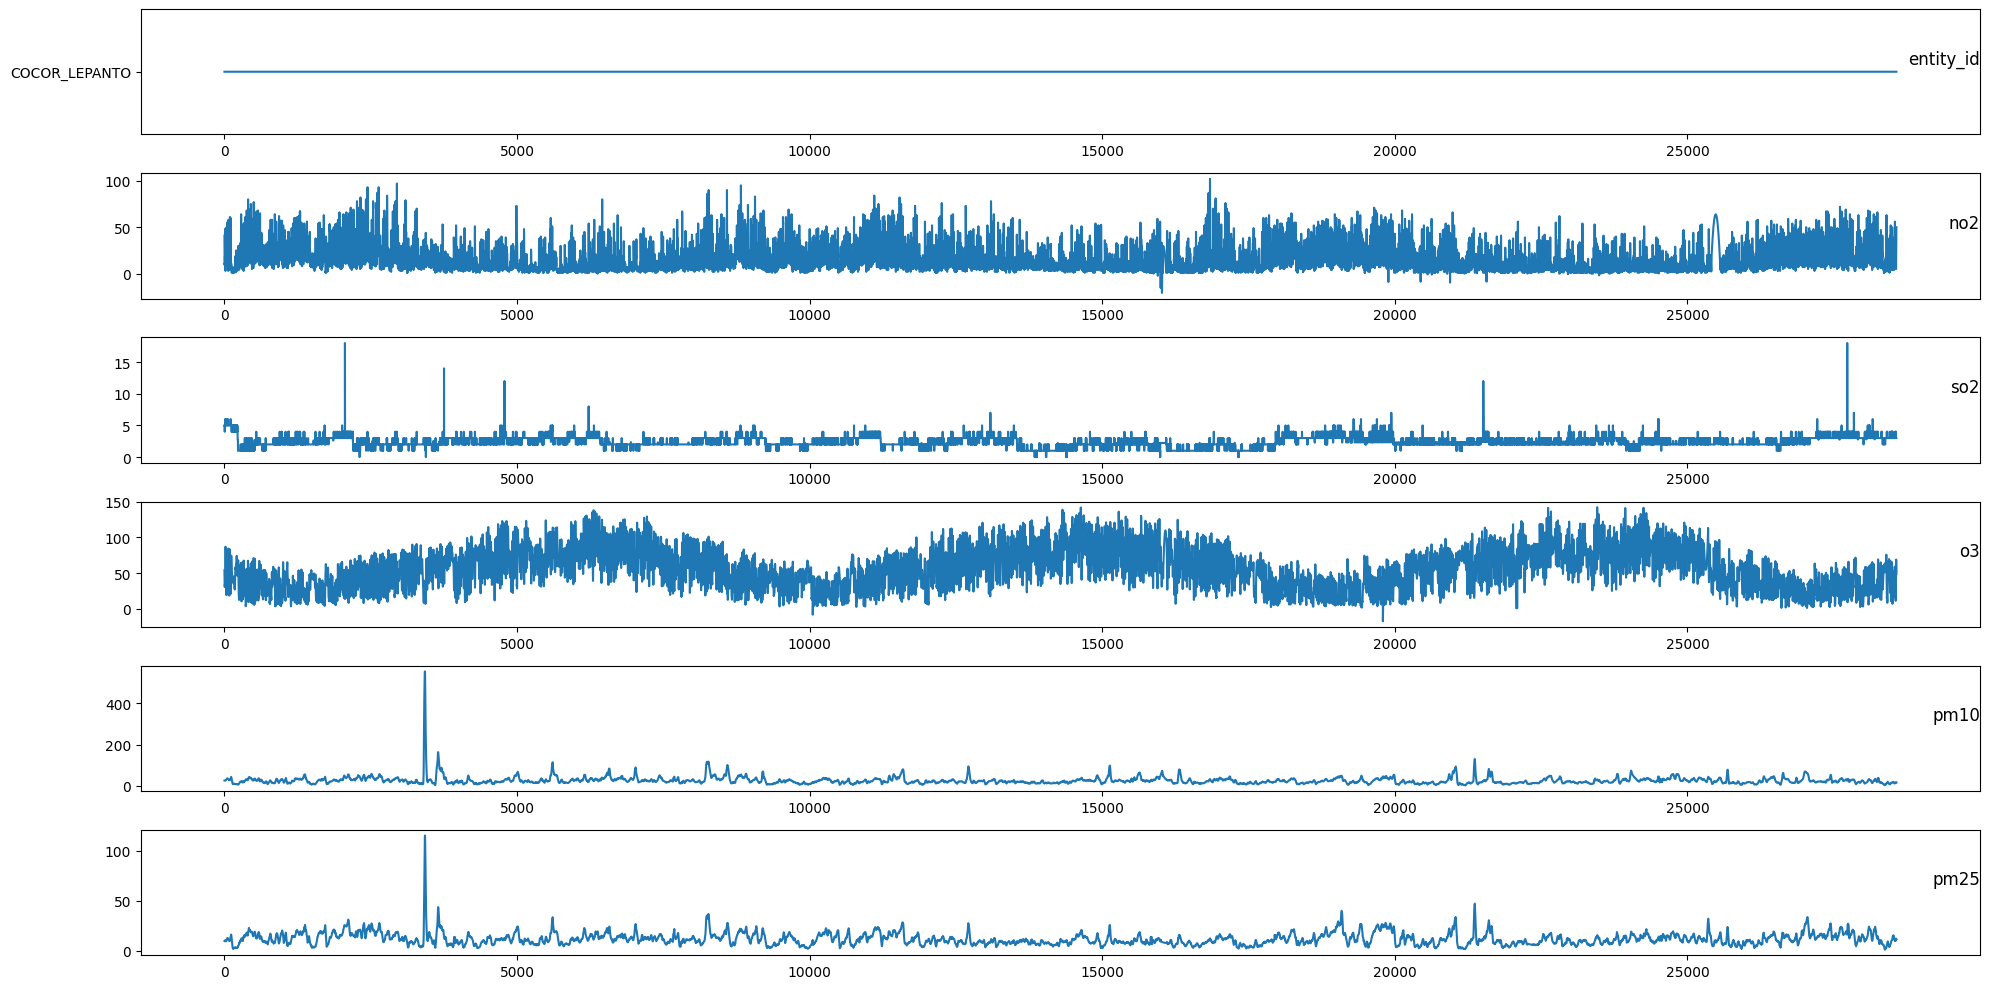

Descripcion:
                 no2           so2            o3          pm10          pm25
count  28571.000000  28571.000000  28571.000000  28571.000000  28571.000000
mean      14.671096      2.406758     54.638677     26.537384     11.955602
std       13.111186      0.797509     29.107163     20.286144      6.309278
min      -20.660745      0.000000    -17.256031      2.796000      1.197000
25%        6.000000      2.000000     31.375000     16.588000      7.800000
50%       10.000000      2.000000     53.078000     23.130000     10.865000
75%       19.000000      3.000000     75.429000     31.556566     15.040000
max      102.000000     18.000000    142.125000    552.568000    115.375000
Correlación entre las variables:
            no2       so2        o3      pm10      pm25
no2   1.000000  0.223184 -0.299925  0.086891  0.233345
so2   0.223184  1.000000 -0.172459  0.069719  0.256517
o3   -0.299925 -0.172459  1.000000 -0.011198 -0.201459
pm10  0.086891  0.069719 -0.011198  1.000000  0.

In [3]:
##############
# ESTUDIO Columnas
################

plot_columns(df, [0,1,2, 3, 4, 5])
dff=df.drop(columns=["entity_id"])
print("===================\nDescripcion:\n",df.describe())
print("===================\nCorrelación entre las variables:\n",dff.corr())

Viendo las correlaciones de las variables, concluimos que lo mejore es crear:
* 1 Modelo_NO2 basado en los datos historicos del NO2
* 1 Modelo_SO2 basado en los datos historicos del SO2
* 1 Modelo_O3 basado en los datos historicos del O3
* 1 Modelo_PM10 basado en los datos historicos del PM10 y PM25
* 1 Modelo_PM25 basado en los datos historicos del PM25 y PM10


Si la correlacion entre las variables fuera mas alta (>0'8) como en el caso de pm10 y pm25 entonces meteriamos esas variables en los modelos correspondientes


# O3

### Visualización Clásica (Tendencia, estacionalidad, estacionariedad)

Resample por D:
 time_index
2021-10-25    51.581522
2021-10-26    45.864583
2021-10-27    50.010417
2021-10-28    47.458333
2021-10-29    44.546458
Freq: D, Name: o3, dtype: float64
Media Deslizante (ventana de 720):
 time_index
2021-10-25 01:00:00   NaN
2021-10-25 02:00:00   NaN
2021-10-25 03:00:00   NaN
2021-10-25 04:00:00   NaN
2021-10-25 05:00:00   NaN
2021-10-25 06:00:00   NaN
2021-10-25 07:00:00   NaN
2021-10-25 08:00:00   NaN
2021-10-25 09:00:00   NaN
2021-10-25 10:00:00   NaN
Name: o3, dtype: float64


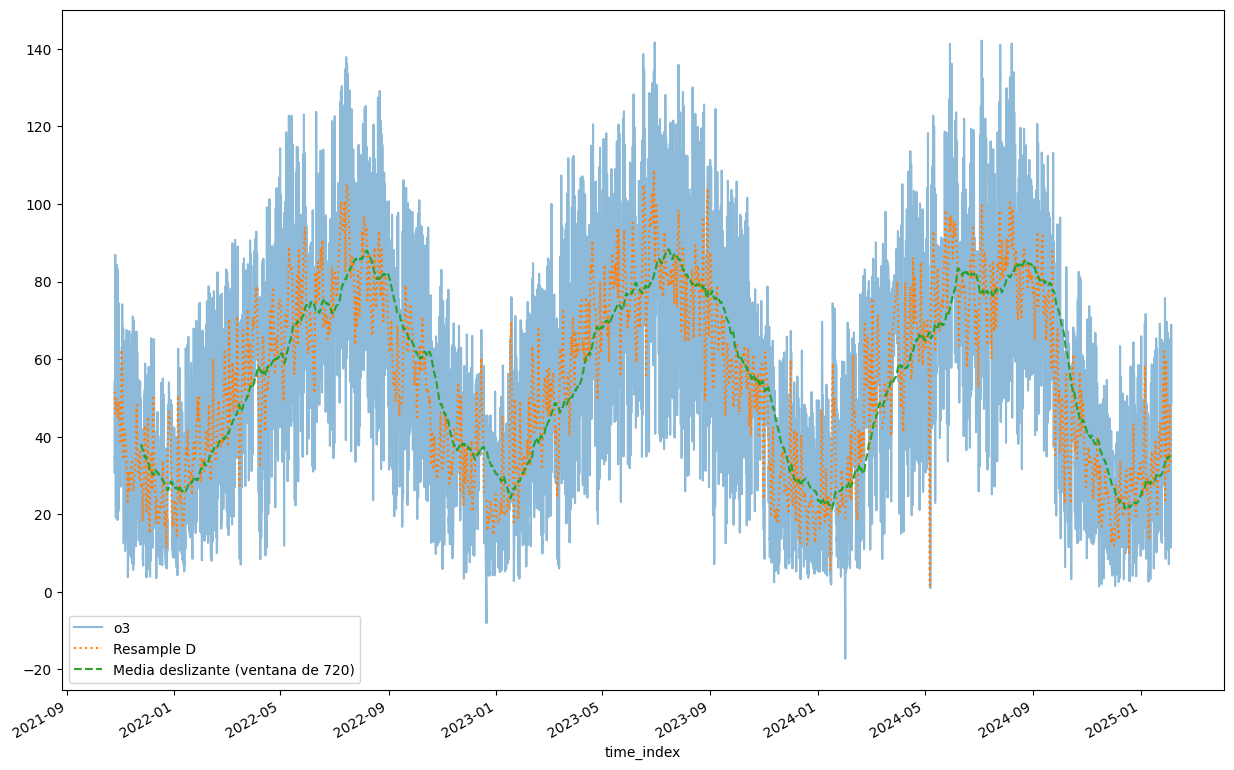

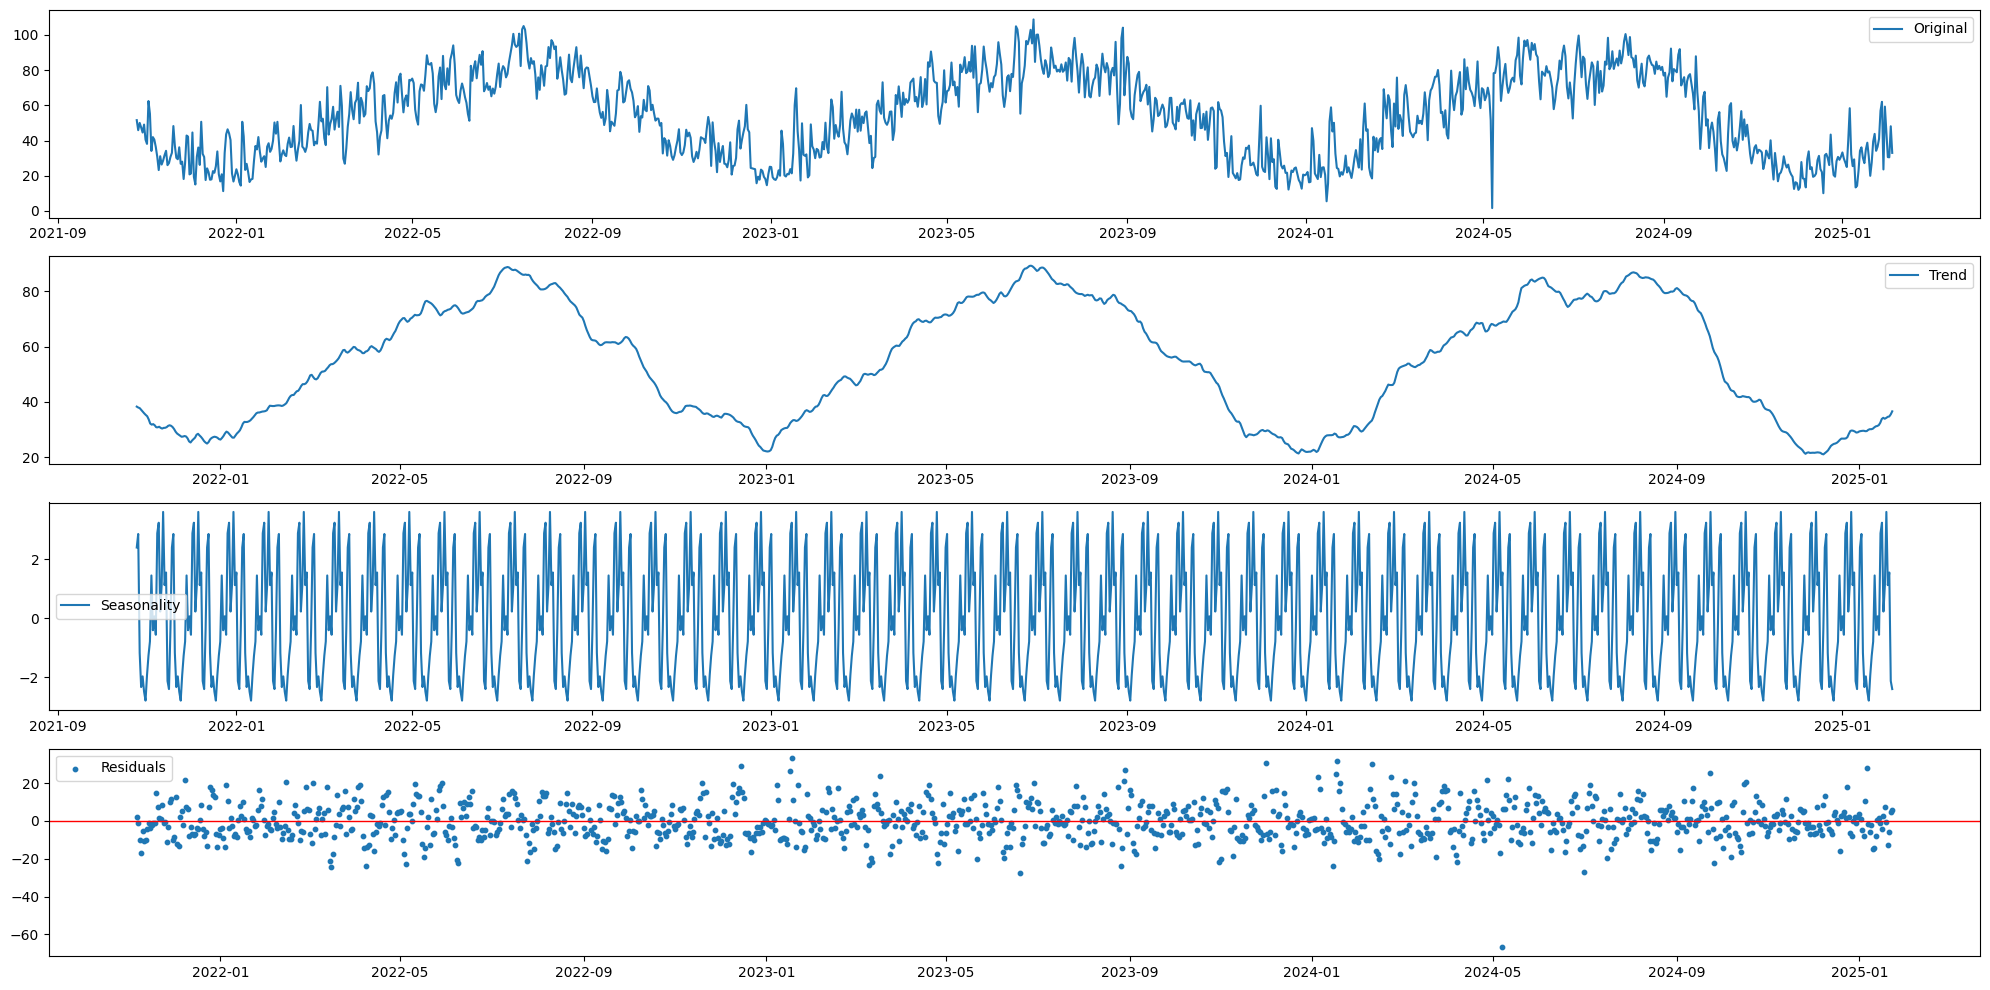

In [4]:
###########
# Visualizacion y descomposicion serie temporal
#####################

o3=df["o3"]
o3_resample=resample_and_plot(o3)
o3_descomposicion=decompose_and_plot(o3_resample)

## Procesamiento y Modelado

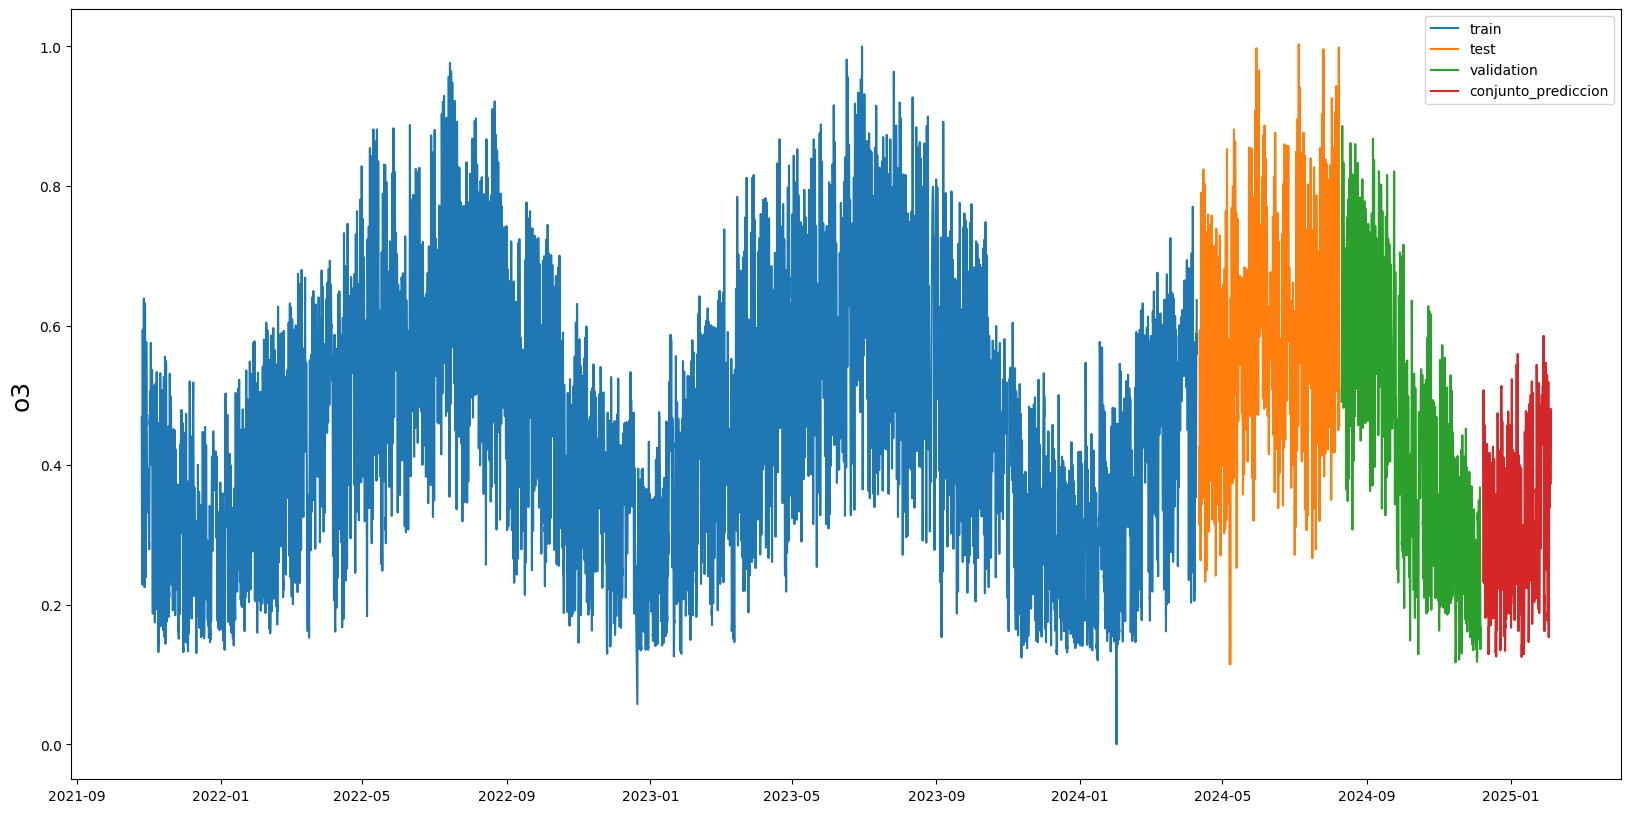

 Estructura DF:


,o3,x_lag_1,x_lag_2,x_lag_3,x_lag_4,x_lag_5,x_rmean_24,x_diff1,x_diff24,x_rmean_24f,year,month,dayofweek,hour,date
time_index,,,,,,,,,,,,,,,
2021-10-26 01:00:00,0.468156,0.516147,0.571220,0.626293,0.633373,0.655403,0.437505,-0.047992,0.018882,0.395119,2021,10,1,1,2021-10-26
2021-10-26 02:00:00,0.426458,0.468156,0.516147,0.571220,0.626293,0.633373,0.438947,-0.041698,0.034617,0.394135,2021,10,1,2,2021-10-26
2021-10-26 03:00:00,0.372172,0.426458,0.468156,0.516147,0.571220,0.626293,0.439996,-0.054286,0.025176,0.394266,2021,10,1,3,2021-10-26
2021-10-26 04:00:00,0.354863,0.372172,0.426458,0.468156,0.516147,0.571220,0.441340,-0.017309,0.032257,0.395283,2021,10,1,4,2021-10-26
2021-10-26 05:00:00,0.356437,0.354863,0.372172,0.426458,0.468156,0.516147,0.443143,0.001574,0.043271,0.395512,2021,10,1,5,2021-10-26


In [5]:
#######################
# Procesamiento 
#######################
# Calculamos el indice correspondiente al 80% de los datos
index=int(o3.shape[0]*0.75)
index2=int(o3.shape[0]*0.85)
index3=int(o3.shape[0]*0.95)

# Dividimos el dataframe en train y test
o3_train=o3.iloc[:index] # Para entrenar
o3_test=o3.iloc[index:index2]  # Para ranking de modelos i
o3_val=o3.iloc[index2:index3]  # Para evaluar rendimiento
o3_prediccion=o3.iloc[index3:] # Para predecir

# Normalizamos los conjuntos
o3_train, o3_test,o3_val, min_max = normalizacion(o3_train, o3_test, o3_val)
o3_prediccion=(o3_prediccion-min_max[0])/(min_max[1]-min_max[0])

#Procesamos
o3_train=procesamiento(o3_train)
o3_test=procesamiento(o3_test)
o3_val=procesamiento(o3_val)
o3_prediccion=procesamiento(o3_prediccion)

#Dibujamos la division
plt.figure(figsize=(20,10))
plt.plot(o3_train.index, o3_train['o3'], label='train')
plt.plot(o3_test.index, o3_test['o3'], label='test')
plt.plot(o3_val.index, o3_val['o3'], label='validation')
plt.plot(o3_prediccion.index, o3_prediccion['o3'], label='conjunto_prediccion')
plt.ylabel('o3', fontsize=18)
plt.legend()
plt.show()

print("=======\n Estructura DF:")
o3_train.head()

In [6]:
####################
# MODELAMOS
###################
h2o.init()

# Convertimos los datos a un objeto H2OFrame
o3_train_h2o = h2o.H2OFrame(o3_train,destination_frame="COCOR_LEPANTO_o3_train")
o3_test_h2o = h2o.H2OFrame(o3_test,destination_frame="COCOR_LEPANTO_o3_test")
o3_val_h2o = h2o.H2OFrame(o3_val,destination_frame="COCOR_LEPANTO_o3_val")
o3_prediccion_h2o = h2o.H2OFrame(o3_prediccion,destination_frame="COCOR_LEPANTO_o3_prediccion")


# Definimos variables dependientes e independientes
x = o3_train_h2o.columns
y = 'o3'
x.remove(y)

Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,1 hour 54 mins
H2O_cluster_timezone:,UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,3 months and 10 days
H2O_cluster_name:,root
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.498 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [15]:
from h2o.automl import H2OAutoML
# Definimos el modelo autoML
o3_aml = H2OAutoML(max_runtime_secs = 600,
                seed = 42,
                verbosity="info",
                stopping_metric="RMSE",
                sort_metric="RMSE",
                keep_cross_validation_predictions=False, #quitamos validacion cruzada
                nfolds=0, #quitamos validacion cruzada
                project_name="COCOR_LEPANTO_aml_o3",
                stopping_rounds=1,
                stopping_tolerance=1e-4)
#Lo entrenamos
o3_aml.train(x = x, 
          y = y,
          training_frame = o3_train_h2o,
          leaderboard_frame = o3_test_h2o)#,
          #validation_frame = o3_val_h2o)

# guardamos el modelo en disco
model_path = h2o.save_model(model=o3_aml.leader, path="COCOR_LEPANTO_leader_o3", force=True)

AutoML progress: |
12:45:38.947: Project: COCOR_LEPANTO_aml_o3
12:45:38.948: Cross-validation disabled by user: no fold column nor nfolds > 1.
12:45:38.948: Stopping tolerance set by the user: 1.0E-4
12:45:38.948: Stopping tolerance set by the user is < 70% of the recommended default of 0.0068390558377677225, so models may take a long time to converge or may not converge at all.
12:45:38.948: Build control seed: 42
12:45:38.953: Since cross-validation is disabled, and validation frame(s) were not provided, automatically split the training data into training, validation frame(s) in the ratio 90/10/0.
12:45:39.18: training frame: Frame key: AutoML_1_20250207_124538_training_COCOR_LEPANTO_o3_train    cols: 15    rows: 19206  chunks: 2    size: 1769024  checksum: -1758390459596120089
12:45:39.24: validation frame: Frame key: AutoML_1_20250207_124538_validation_COCOR_LEPANTO_o3_train    cols: 15    rows: 2174  chunks: 2    size: 202080  checksum: 1899092064915469042
12:45:39.24: leaderboard

In [45]:
h2o.save_model(model=aml.leader, path="AKIIIIIIIIII", force=True)

#GUARDAMOS EL MODELO CON EL NOMBRE de forma local
aml.leader.download_mojo(path="COCOR_LEPANTO_leader_o3", get_genmodel_jar=True)

'/home/p3j0t4/0.CITRIDATA/0.Fiware/0_Retos/0.Reto_2/COCOR_LEPANTO_leader_o3/StackedEnsemble_BestOfFamily_3_AutoML_1_20250206_113157.zip'

In [16]:
# Mostramos el leaderboard
o3_lb = o3_aml.leaderboard
print("==================\nClasificación de los métodos:\n")
print(o3_lb.head(rows=o3_lb.nrows))

# Evaluar el rendimiento en el conjunto de prediccion
predict_performance = o3_aml.leader.model_performance(o3_prediccion_h2o)
print("====================\nRendimiento en el conjunto de validación:\n")
print(predict_performance)
print("\n==============\nR² en el conjunto de prediccion:", predict_performance.r2())

Clasificación de los métodos:

model_id                                                     rmse          mse         mae       rmsle    mean_residual_deviance
DeepLearning_grid_1_AutoML_1_20250207_124538_model_2   0.00249943  6.24717e-06  0.00176247  0.00163781               6.24717e-06
GLM_1_AutoML_1_20250207_124538                         0.00266814  7.11896e-06  0.00126249  0.00171245               7.11896e-06
DeepLearning_1_AutoML_1_20250207_124538                0.00359889  1.2952e-05   0.00235467  0.00217595               1.2952e-05
GBM_grid_1_AutoML_1_20250207_124538_model_81           0.00781065  6.10062e-05  0.00151218  0.00533301               6.10062e-05
GBM_grid_1_AutoML_1_20250207_124538_model_31           0.00795952  6.3354e-05   0.00178794  0.00545273               6.3354e-05
XGBoost_grid_1_AutoML_1_20250207_124538_model_4        0.0080154   6.42467e-05  0.0034056   0.00531472               6.42467e-05
GBM_grid_1_AutoML_1_20250207_124538_model_25           0.00804693  6

In [17]:
##################
# Predicciones 
##################

#realizamos las predicciones
pred=o3_aml.leader.predict(o3_prediccion_h2o)


#Creamos una tabla comparativa y_true vs y_pred
df_result=pd.DataFrame()
df_result["y_true"]=normalizacion_inversa(o3_prediccion['o3'].reset_index(drop=True), min_max[0], min_max[1])
df_result["y_pred"]=normalizacion_inversa(h2o.as_list(pred,use_pandas=True), min_max[0], min_max[1])


from scipy import stats
slope, intercept, r_value, p_value, std_err = stats.linregress(x=df_result['y_pred'],y=df_result['y_true'])
print('R2 = ',r_value*r_value)
df_result.head()


deeplearning prediction progress: |

██████████████████████████████████████████████| (done) 100%
R2 =  0.9998705471080854


/home/p3j0t4/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,y_true,y_pred
0,19.875,20.507640
1,26.000,26.695855
2,31.750,32.222976
3,37.500,38.235205
4,43.875,44.731746


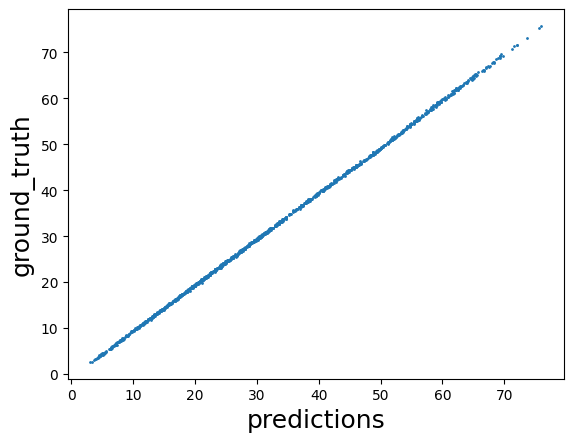

In [18]:
plt.scatter(x=df_result['y_pred'],y=df_result['y_true'],s=1)
plt.xlabel('predictions',fontsize=18)
plt.ylabel('ground_truth',fontsize=18)
plt.show()

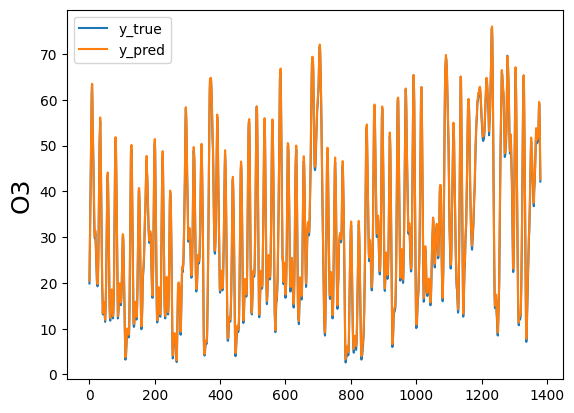

In [19]:
plt.plot(df_result['y_true'])
plt.plot(df_result['y_pred'])
plt.ylabel('O3',fontsize=18)
plt.legend(['y_true','y_pred'])
plt.show()

### Predicciones 24h proximas

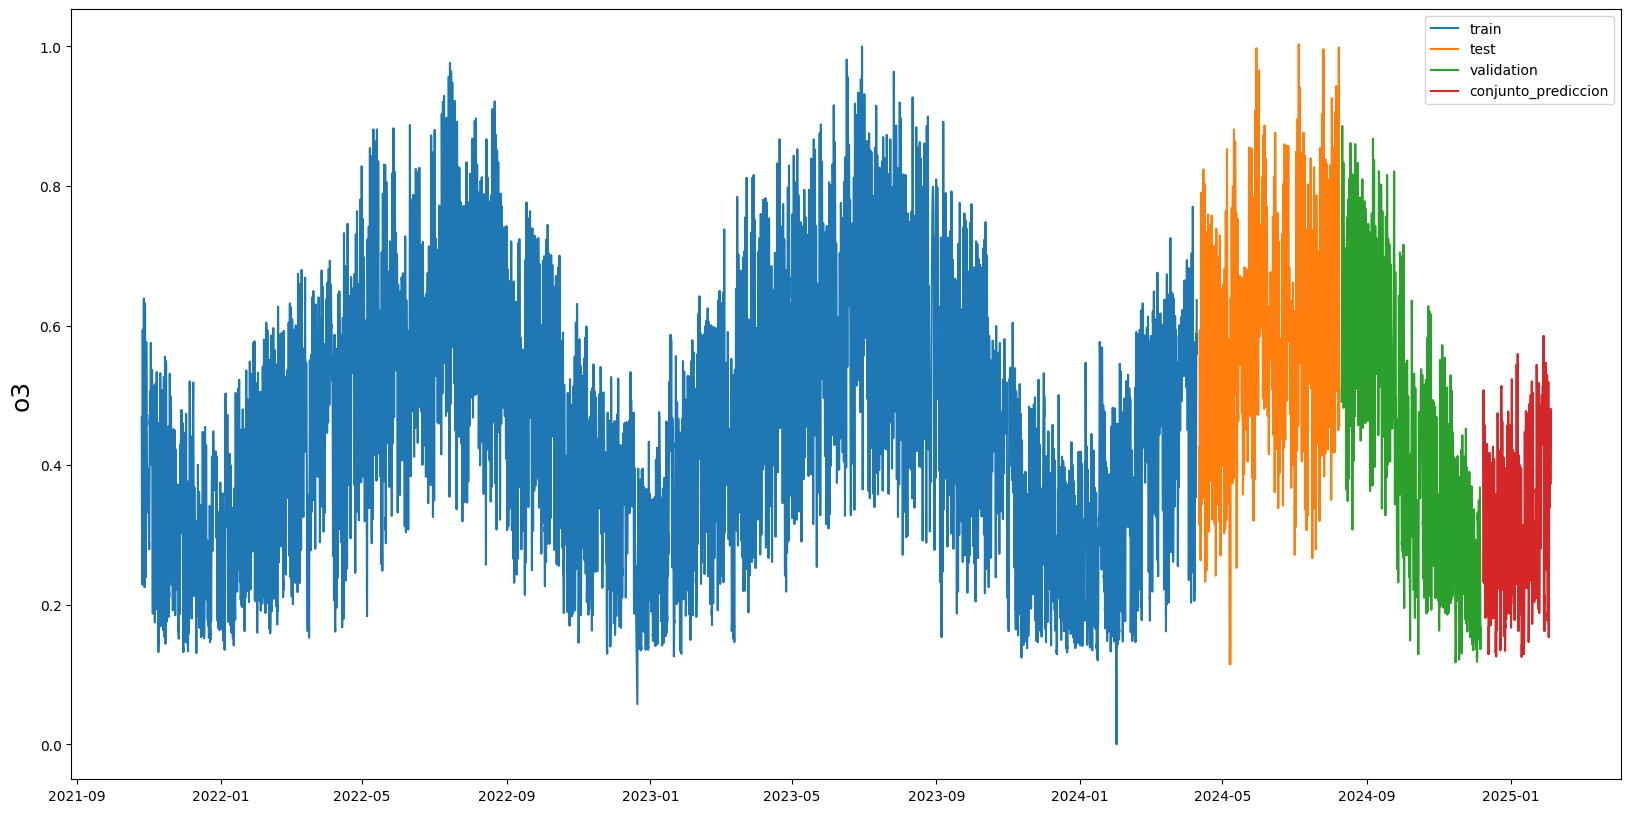

,o3,x_next24,x_lag_1,x_lag_2,x_lag_3,x_lag_4,x_lag_5,x_lag_6,x_lag_7,x_lag_8,...,x_lag_24,x_rmean_24,x_diff1,x_diff24,x_rmean_24f,year,month,dayofweek,hour,date
time_index,,,,,,,,,,,,,,,,,,,,,
2021-10-26 01:00:00,0.468156,0.438259,0.516147,0.571220,0.626293,0.633373,0.655403,0.645175,0.594823,0.535029,...,0.449273,0.437505,-0.047992,0.018882,0.395119,2021,10,1,1,2021-10-26
2021-10-26 02:00:00,0.426458,0.402855,0.468156,0.516147,0.571220,0.626293,0.633373,0.655403,0.645175,0.594823,...,0.391841,0.438947,-0.041698,0.034617,0.394135,2021,10,1,2,2021-10-26
2021-10-26 03:00:00,0.372172,0.375319,0.426458,0.468156,0.516147,0.571220,0.626293,0.633373,0.655403,0.645175,...,0.346996,0.439996,-0.054286,0.025176,0.394266,2021,10,1,3,2021-10-26
2021-10-26 04:00:00,0.354863,0.379253,0.372172,0.426458,0.468156,0.516147,0.571220,0.626293,0.633373,0.655403,...,0.322606,0.441340,-0.017309,0.032257,0.395283,2021,10,1,4,2021-10-26
2021-10-26 05:00:00,0.356437,0.361944,0.354863,0.372172,0.426458,0.468156,0.516147,0.571220,0.626293,0.633373,...,0.313165,0.443143,0.001574,0.043271,0.395512,2021,10,1,5,2021-10-26
2021-10-26 06:00:00,0.322606,0.372959,0.356437,0.354863,0.372172,0.426458,0.468156,0.516147,0.571220,0.626293,...,0.301364,0.444028,-0.033830,0.021242,0.397610,2021,10,1,6,2021-10-26
2021-10-26 07:00:00,0.316312,0.344635,0.322606,0.356437,0.354863,0.372172,0.426458,0.468156,0.516147,0.571220,...,0.316312,0.444028,-0.006294,0.000000,0.398790,2021,10,1,7,2021-10-26
2021-10-26 08:00:00,0.296644,0.324967,0.316312,0.322606,0.356437,0.354863,0.372172,0.426458,0.468156,0.516147,...,0.323393,0.442914,-0.019669,-0.026750,0.399970,2021,10,1,8,2021-10-26
2021-10-26 09:00:00,0.265960,0.313165,0.296644,0.316312,0.322606,0.356437,0.354863,0.372172,0.426458,0.468156,...,0.328900,0.440291,-0.030683,-0.062940,0.401937,2021,10,1,9,2021-10-26


In [13]:
def procesamiento2(df,lag,delay=24):
    """
    Procesa la serie temporal 'df' añadiendo columnas de valores lagged, media móvil,
    diferencias, y variables temporales.

    Args:
    o3 (pd.Series): Serie temporal con un índice de fecha y hora.

    Returns:
    pd.DataFrame: DataFrame procesado con las nuevas columnas.
    """
    try:
        final_df = df.copy().to_frame()
    except:
        final_df = df.copy()
    
    final_df["x_next24"] = df.shift(-24) # <---------------------------------------------------------- VARIABLE A INFERIR

    # Añadimos 5 columnas con los valores lagged de las últimas 5 horas
    for i in range(1, lag+1):
        final_df["x_lag_" + str(i)] = df.shift(i)

    # Añadimos una columna con la media móvil de las últimas 24h
    final_df["x_rmean_24"] = df.rolling(window=delay).mean()

    # Añadimos una columna con las diferencias entre xn y xn+1
    final_df["x_diff1"] = df.diff(1)  # Esto aproxima la derivada de la serie por Newton-Raphson f'=f(x)-f(x-1)/(x-(x-1))

    # Añadimos una columna con las diferencias entre xn y xn+24
    final_df["x_diff24"] = df.diff(24)

    # Añadimos una columna con la media de las proximas 24h
    final_df["x_rmean_24f"] = df.shift(-24).rolling(window=24).mean()

    # Añadimos columnas referente al mes y al día de la semana de la instancia
    final_df["year"] = df.index.year
    final_df["year"]=final_df["year"].astype(int)
    final_df["month"] = df.index.month
    final_df["month"]=final_df["month"].astype(int)
    final_df["dayofweek"] = df.index.dayofweek
    final_df["dayofweek"]=final_df["dayofweek"].astype(int)
    final_df["hour"] = df.index.hour
    final_df["hour"]=final_df["hour"].astype(int)
    final_df["date"] = df.index.date

    # Eliminamos los valores NaN (con esto perdemos los primeros 24 datos, que como tenemos tantos días no es relevante)
    final_df.dropna(inplace=True)

    return final_df

# Partimos del original

df2=o3.copy()

#dividimos en train, test, val y pred 
train2=df2.iloc[:index] # Para entrenar
test2=df2.iloc[index:index2]  # Para testear
val2=df2.iloc[index2:index3]  # Para evaluar rendimiento
pred2=df2.iloc[index3:] # Para predecir

# Normalizamos los conjuntos
train2, test2,val2, min_max = normalizacion(train2, test2, val2)
pred2=(pred2-min_max[0])/(min_max[1]-min_max[0])

#Procesamos
train2=procesamiento2(train2,24)
test2=procesamiento2(test2,24)
val2=procesamiento2(val2,24)
pred2=procesamiento2(pred2,24)

#Dibujamos la division
plt.figure(figsize=(20,10))
plt.plot(train2.index, train2['o3'], label='train')
plt.plot(test2.index, test2['o3'], label='test')
plt.plot(val2.index, val2['o3'], label='validation')
plt.plot(pred2.index, pred2['o3'], label='conjunto_prediccion')
plt.ylabel('o3', fontsize=18)
plt.legend()
plt.show()
       

train2.head(48)





In [14]:
# subimos datos a h2o
train2_h2o = h2o.H2OFrame(train2,destination_frame="COCOR_LEPANTO_o3_train2")
test2_h2o = h2o.H2OFrame(test2,destination_frame="COCOR_LEPANTO_o3_test2")
val2_h2o = h2o.H2OFrame(val2,destination_frame="COCOR_LEPANTO_o3_val2")
pred2_h2o = h2o.H2OFrame(pred2,destination_frame="COCOR_LEPANTO_o3_pred2")

# Definimos variables dependientes e independientes
x = train2_h2o.columns
y = 'x_next24'
x.remove(y)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [ ]:
#Definimos el modelo autoML
from h2o.automl import H2OAutoML
h2o.init()
o3_aml2 = H2OAutoML(max_runtime_secs =3600,
                seed = 42,
                verbosity="info",
                stopping_metric="deviance",
                sort_metric="RMSE",
                keep_cross_validation_predictions=False,
                nfolds=0,
                project_name="COCOR_LEPANTO_aml_o3_2.1",
                )

#entrenamos el modelo
o3_aml2.train(x = x, 
          y = y,
          training_frame = train2_h2o, #conjunto entrenamiento (para entrenar)
          leaderboard_frame = test2_h2o, #conjunto leaderboard (para ranking de modelos)
          validation_frame = val2_h2o) #conjunto validacion (para evaluar rendimiento)



Checking whether there is an H2O instance running at http://localhost:54321. connected.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,2 hours 56 mins
H2O_cluster_timezone:,UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,3 months and 10 days
H2O_cluster_name:,root
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.100 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"


AutoML progress: |
10:18:35.185: Project: COCOR_LEPANTO_aml_o3_2.1
10:18:35.186: Cross-validation disabled by user: no fold column nor nfolds > 1.
10:18:35.186: Setting stopping tolerance adaptively based on the training frame: 0.0068390558377677225
10:18:35.186: Build control seed: 42
10:18:35.187: training frame: Frame key: AutoML_1_20250212_101835_training_COCOR_LEPANTO_o3_train2    cols: 35    rows: 21380  chunks: 4    size: 5392995  checksum: -4479433254867729156
10:18:35.187: validation frame: Frame key: COCOR_LEPANTO_o3_val2    cols: 35    rows: 2809  chunks: 1    size: 707451  checksum: -2673928707538067558
10:18:35.187: leaderboard frame: Frame key: COCOR_LEPANTO_o3_test2    cols: 35    rows: 2809  chunks: 1    size: 707451  checksum: -2711689474056281506
10:18:35.187: blending frame: NULL
10:18:35.187: response column: x_next24
10:18:35.187: fold column: null
10:18:35.187: weights column: null
10:18:35.197: Loading execution steps: [{XGBoost : [def_2 (1g, 10w), def_1 (2g, 10w

In [ ]:
#importamos stats
from scipy import stats

#Realizamos las predicciones en el conjunto de predicción
pred22=o3_aml2.leader.predict(pred2_h2o)

#Creamos una tabla comparativa y_true vs y_pred con su indice temporal correcto

df_result2=pd.DataFrame()
df_result2["y_true"]=normalizacion_inversa(pred2["x_next24"].reset_index(drop=False), min_max[0], min_max[1])
df_result2["y_pred"]=normalizacion_inversa(h2o.as_list(pred22,use_pandas=False), min_max[0], min_max[1])


#Calculamos el R2
slope, intercept, r_value, p_value, std_err = stats.linregress(x=df_result2['y_pred'],y=df_result2['y_true'])
print('R2 = ',r_value*r_value)

df_result2.head(24)


gbm prediction progress: |

███████████████████████████████████████████████████████| (done) 100%
R2 =  0.6254882088607755


/home/p3j0t4/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,y_true,y_pred
0,19.375,30.869173
1,19.250,27.738249
2,21.125,30.991817
3,24.875,29.908065
4,30.125,36.361234
5,37.250,42.268727
6,44.500,46.962896
7,50.250,50.517766
8,53.000,49.283247
9,55.375,48.478797


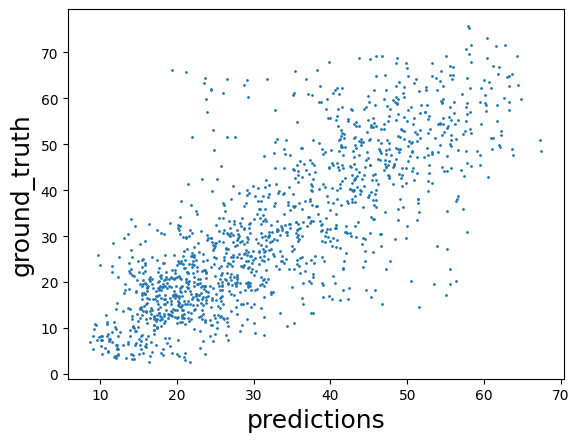

In [23]:
plt.scatter(x=df_result2['y_pred'],y=df_result2['y_true'],s=1)
plt.xlabel('predictions',fontsize=18)
plt.ylabel('ground_truth',fontsize=18)
plt.show()

<Axes: >

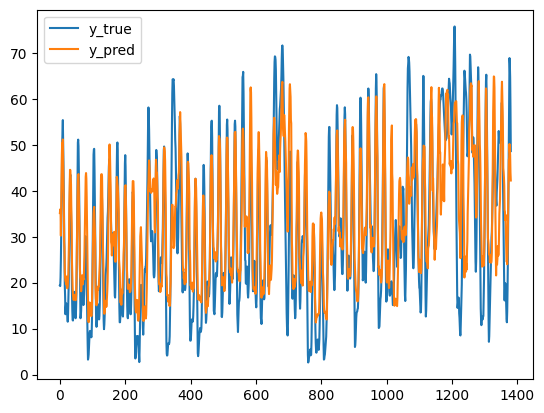

In [20]:
df_result2.plot()

# SO2

### Visualización Clásica (Tendencia, estacionalidad, estacionariedad)

Resample por D:
 time_index
2021-10-25    5.086957
2021-10-26    5.083333
2021-10-27    5.041667
2021-10-28    5.000000
2021-10-29    5.083333
Freq: D, Name: so2, dtype: float64
Media Deslizante (ventana de 720):
 time_index
2021-10-25 01:00:00   NaN
2021-10-25 02:00:00   NaN
2021-10-25 03:00:00   NaN
2021-10-25 04:00:00   NaN
2021-10-25 05:00:00   NaN
2021-10-25 06:00:00   NaN
2021-10-25 07:00:00   NaN
2021-10-25 08:00:00   NaN
2021-10-25 09:00:00   NaN
2021-10-25 10:00:00   NaN
Name: so2, dtype: float64


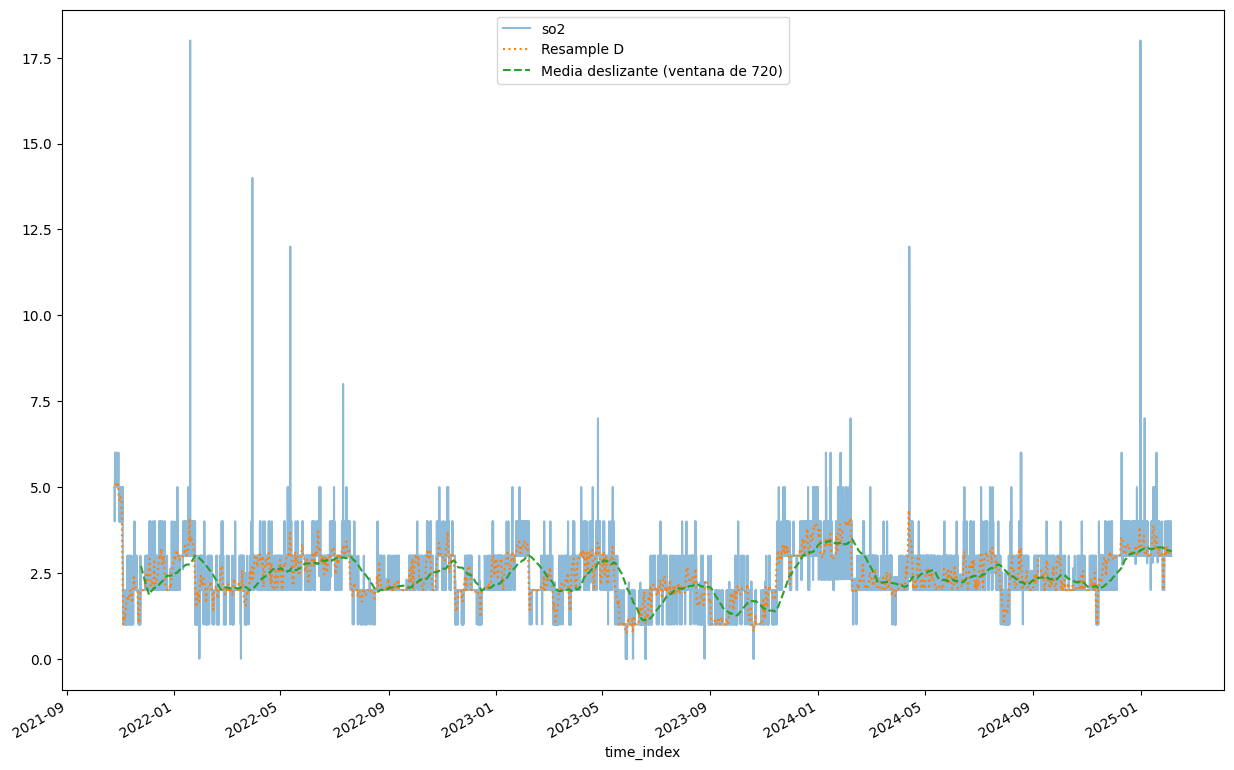

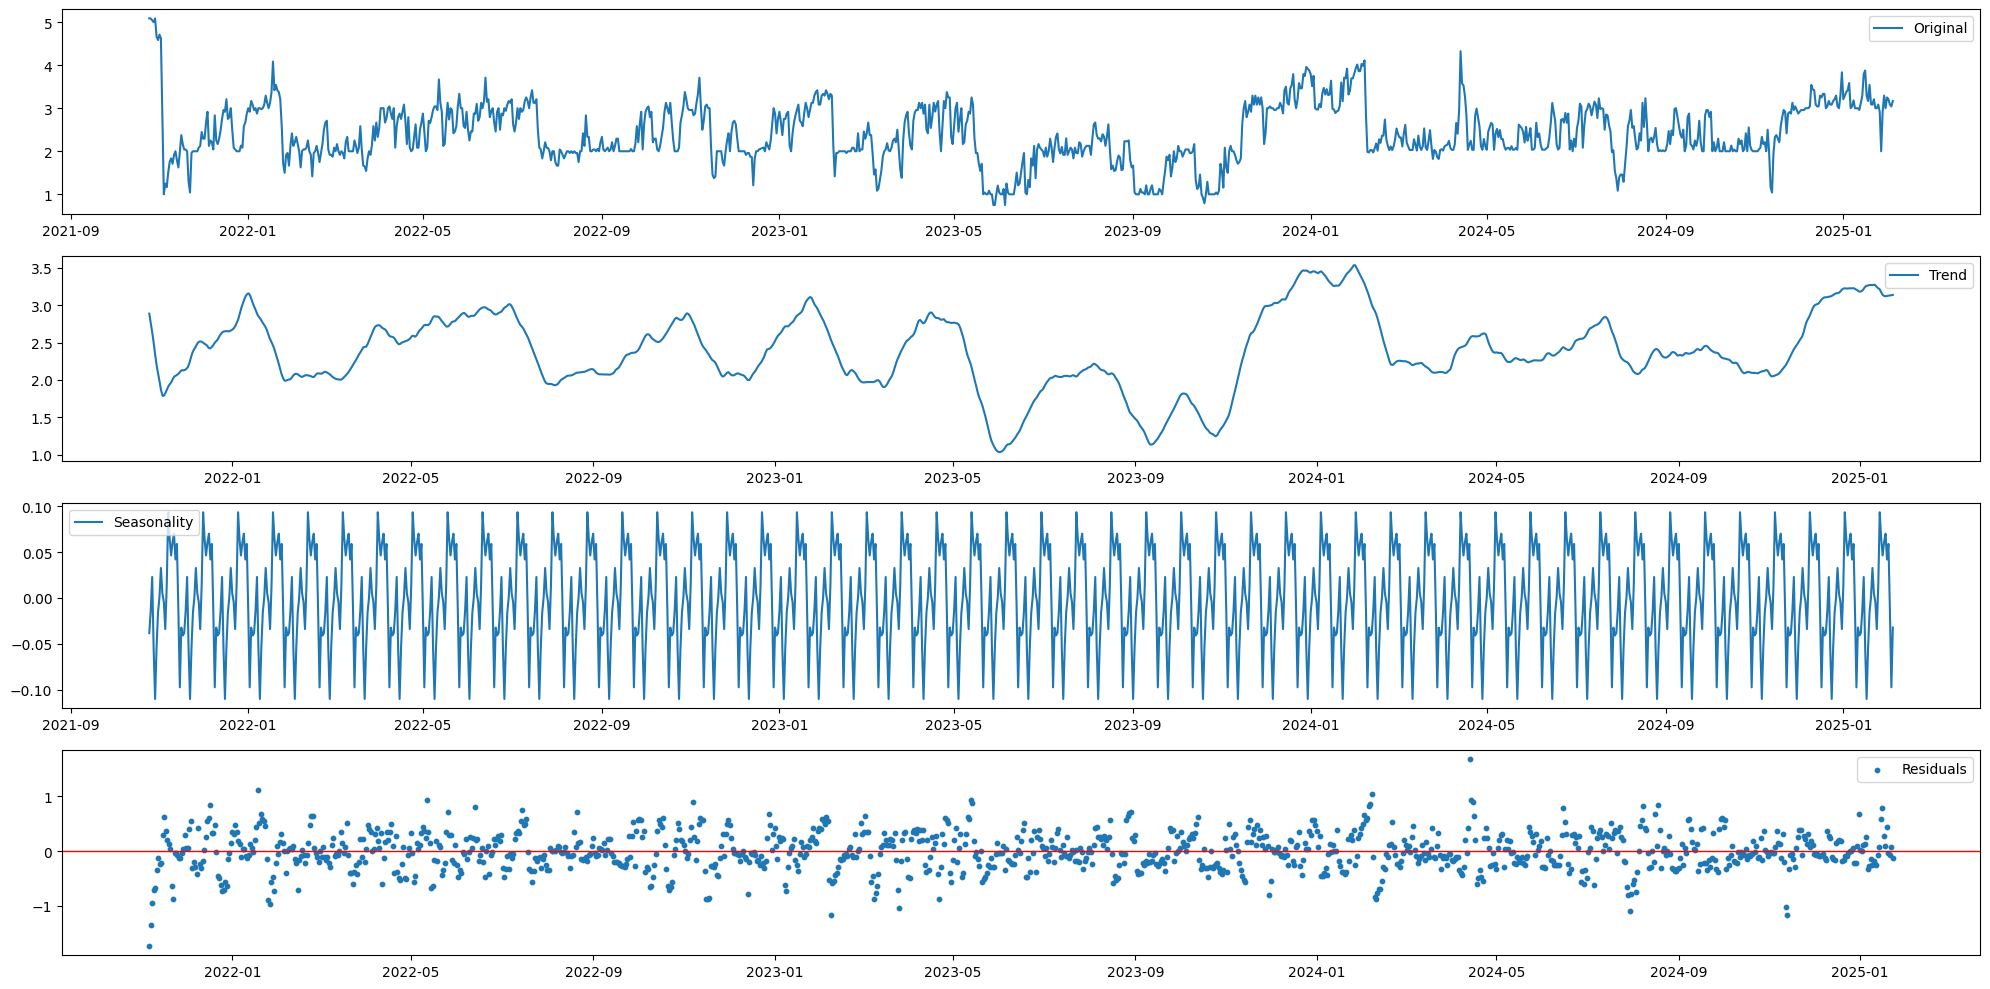

In [24]:
so2=df["so2"]
so2_resample=resample_and_plot(so2)
so2_descomposicion=decompose_and_plot(so2_resample)

## Procesamiento y Modelado

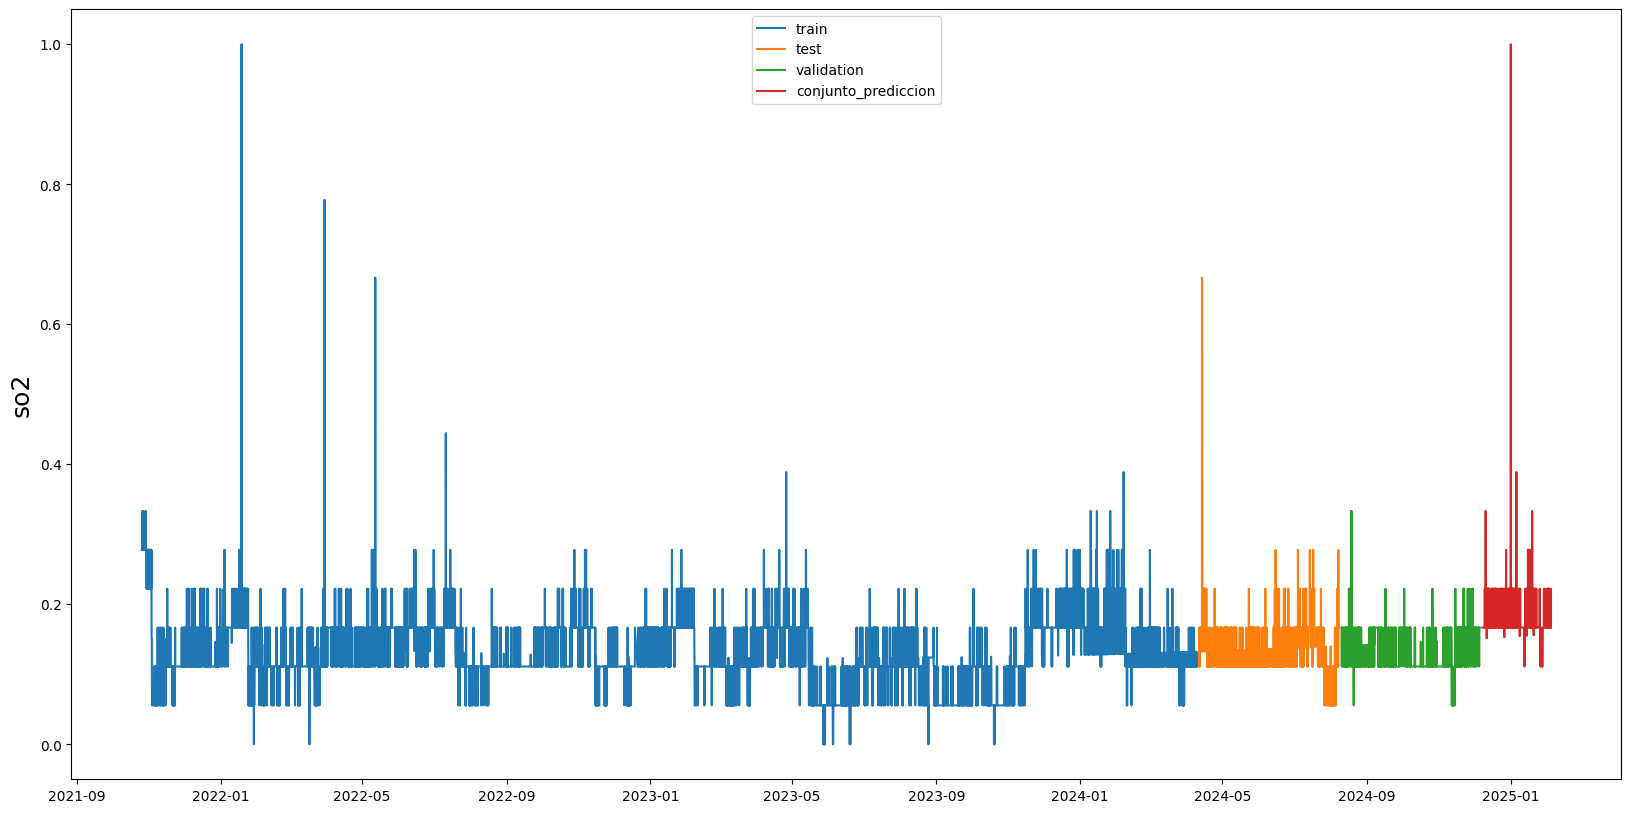

 Estructura DF:


,so2,x_lag_1,x_lag_2,x_lag_3,x_lag_4,x_lag_5,x_rmean_24,x_diff1,x_diff24,x_rmean_24f,year,month,dayofweek,hour,date
time_index,,,,,,,,,,,,,,,
2021-10-26 01:00:00,0.277778,0.277778,0.277778,0.277778,0.277778,0.277778,0.282407,0.0,0.0,0.282407,2021,10,1,1,2021-10-26
2021-10-26 02:00:00,0.277778,0.277778,0.277778,0.277778,0.277778,0.277778,0.282407,0.0,0.0,0.282407,2021,10,1,2,2021-10-26
2021-10-26 03:00:00,0.277778,0.277778,0.277778,0.277778,0.277778,0.277778,0.282407,0.0,0.0,0.282407,2021,10,1,3,2021-10-26
2021-10-26 04:00:00,0.277778,0.277778,0.277778,0.277778,0.277778,0.277778,0.282407,0.0,0.0,0.282407,2021,10,1,4,2021-10-26
2021-10-26 05:00:00,0.277778,0.277778,0.277778,0.277778,0.277778,0.277778,0.282407,0.0,0.0,0.282407,2021,10,1,5,2021-10-26


In [25]:
# Division dataframe
so2_train=so2.iloc[:index] # Para entrenar
so2_test=so2.iloc[index:index2]  # Para testear
so2_val=so2.iloc[index2:index3]  # Para evaluar rendimiento
so2_prediccion=so2.iloc[index3:] # Para predecir

# Normalizamos los conjuntos
so2_train, so2_test,so2_val, min_max_so2 = normalizacion(so2_train, so2_test, so2_val)
so2_prediccion=(so2_prediccion-min_max_so2[0])/(min_max_so2[1]-min_max_so2[0])

#Procesamos
so2_train=procesamiento(so2_train)
so2_test=procesamiento(so2_test)
so2_val=procesamiento(so2_val)
so2_prediccion=procesamiento(so2_prediccion)

#Dibujamos la division
plt.figure(figsize=(20,10))
plt.plot(so2_train.index, so2_train['so2'], label='train')
plt.plot(so2_test.index, so2_test['so2'], label='test')
plt.plot(so2_val.index, so2_val['so2'], label='validation')
plt.plot(so2_prediccion.index, so2_prediccion['so2'], label='conjunto_prediccion')
plt.ylabel('so2', fontsize=18)
plt.legend()
plt.show()

print("=======\n Estructura DF:")
so2_train.head()


In [38]:
# Convertimos los datos a un objeto H2OFrame
so2_train_h2o = h2o.H2OFrame(so2_train,destination_frame="COCOR_LEPANTO_so2_train")
so2_test_h2o = h2o.H2OFrame(so2_test,destination_frame="COCOR_LEPANTO_so2_test")
so2_val_h2o = h2o.H2OFrame(so2_val,destination_frame="COCOR_LEPANTO_so2_val")
so2_prediccion_h2o = h2o.H2OFrame(so2_prediccion,destination_frame="COCOR_LEPANTO_so2_prediccion")

#Deefinimos variables dependientes e independientes
x = so2_train_h2o.columns
y = 'so2'
x.remove(y)

Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [39]:
# Modelamos

so2_aml = H2OAutoML(max_runtime_secs = 60,
                seed = 42,
                stopping_metric="deviance",
                sort_metric="RMSE",
                keep_cross_validation_predictions=False, #quitamos validacion cruzada
                nfolds=0, #quitamos validacion cruzada
                project_name="COCOR_LEPANTO_aml_so2",
                stopping_rounds=1,
                stopping_tolerance=1e-4)

# Entrenamos
so2_aml.train(x = x, 
          y = y,
          training_frame = so2_train_h2o,
          leaderboard_frame = so2_test_h2o,
          validation_frame = so2_val_h2o)


AutoML progress: |
13:09:23.406: Stopping tolerance set by the user is < 70% of the recommended default of 0.0068390558377677225, so models may take a long time to converge or may not converge at all.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_3_20250207_130923


GLM Model: summary
    family    link      regularization               lambda_search                                                                number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------  ---------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ---------------------------------------------------------
    gaussian  identity  Ridge ( lambda = 3.842E-6 )  nlambda = 30, lambda.max = 3.8418, lambda.min = 3.842E-6, lambda.1se = -1.0  14                            14                             30                      AutoML_3_20250207_130923_training_COCOR_LEPANTO_so2_train

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 1.565180498248947e-08
RMSE: 0.00012510717398490573
MAE: 8.974218344143036e-05
RMSLE: 0.00010951210585393876
Mean Residual Deviance: 1.565180498248947e-08
R^2: 0.9999924366141008
Null degrees of freedom: 21379
Residual degrees of freedom: 21365
Null deviance: 44.2441513604949
Residual deviance: 0.0003346355905256249
AIC: -323550.07800282317

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 1.389878941345553e-08
RMSE: 0.00011789312708319994
MAE: 8.669510152316147e-05
RMSLE: 0.00010326641920906339
Mean Residual Deviance: 1.389878941345553e-08
R^2: 0.9999848031710559
Null degrees of freedom: 2808
Residual degrees of freedom: 2794
Null deviance: 2.5717837132135797
Residual deviance: 3.904169946239659e-05
AIC: -42815.32595814174

Scoring History: 
     timestamp            duration    iteration    lambda    predictors    deviance_train          deviance_test           alpha    iterations    training_rmse           training_deviance      training_mae           training_r2         validation_rmse         validation_deviance    validation_mae         validation_r2
---  -------------------  ----------  -----------  --------  ------------  ----------------------  ----------------------  -------  ------------  ----------------------  ---------------------  ---------------------  ------------------  ----------------------  ---------------------  ---------------------  ------------------
     2025-02-07 13:09:24  0.000 sec   1            .38E1     15            0.0006068271048614215   0.00034697173616031696  0.0
     2025-02-07 13:09:24  0.015 sec   2            .24E1     15            0.0004482344093313271   0.00027377450441059306  0.0
     2025-02-07 13:09:24  0.019 sec   3            .15E1     15            0.0003322631029943847   0.00021507330641033808  0.0
     2025-02-07 13:09:24  0.023 sec   4            .92E0     15            0.0002498975152664315   0.0001689993548119089   0.0
     2025-02-07 13:09:24  0.026 sec   5            .57E0     15            0.00019041391627597353  0.00013244904075373793  0.0      5             0.00012510717398490573  1.565180498248947e-08  8.974218344143036e-05  0.9999924366141008  0.00011789312708319994  1.389878941345553e-08  8.669510152316147e-05  0.9999848031710559
     2025-02-07 13:09:24  0.031 sec   6            .35E0     15            0.00014282331353363993  0.00010114127471279009  0.0
     2025-02-07 13:09:24  0.036 sec   7            .22E0     15            0.00010390845283415258  7.444734535648039e-05   0.0
     2025-02-07 13:09:24  0.038 sec   8            .14E0     15            7.148585285635003e-05   5.1579228252241146e-05  0.0
     2025-02-07 13:09:24  0.039 sec   9            .85E-1    15            4.566594026851816e-05   3.310622157092033e-05   0.0
     2025-02-07 13:09:24  0.040 sec   10           .53E-1    15            2.694155631864816e-05   1.9626475722884027e-05  0.0
---  ---                  ---         ---          ---       ---           ---                     ---               

In [40]:
# Mostramos el Leaderboard
so2_lb = so2_aml.leaderboard
print("==================\nClasificación de los métodos:\n")
print(so2_lb.head(rows=so2_lb.nrows))

# Evaluar el rendimiento en el conjunto de prediccion
predict_performance = so2_aml.leader.model_performance(so2_prediccion_h2o)
print("====================\nRendimiento en el conjunto de predicción:\n")
print(predict_performance)

print("\n==============\nR² en el conjunto de predicción:", predict_performance.r2())

Clasificación de los métodos:

model_id                                                    rmse          mse          mae        rmsle    mean_residual_deviance
GLM_1_AutoML_3_20250207_130923                        0.00015369  2.36206e-08  0.000107987  0.000131904               2.36206e-08
DeepLearning_1_AutoML_3_20250207_130923               0.00192896  3.72088e-06  0.00122276   0.00161526                3.72088e-06
GBM_5_AutoML_3_20250207_130923                        0.00385415  1.48545e-05  0.00126673   0.00287278                1.48545e-05
GBM_grid_1_AutoML_3_20250207_130923_model_25          0.00465238  2.16446e-05  0.000834775  0.00353489                2.16446e-05
GBM_grid_1_AutoML_3_20250207_130923_model_5           0.00471726  2.22526e-05  0.00176131   0.00369475                2.22526e-05
GBM_grid_1_AutoML_3_20250207_130923_model_24          0.00476395  2.26953e-05  0.000605721  0.00353296                2.26953e-05
GBM_grid_1_AutoML_3_20250207_130923_model_8           0.004

In [41]:
############3333
# Predicciones
#################

#realizamos las predicciones
so2_pred=so2_aml.leader.predict(so2_prediccion_h2o)

#Creamos una tabla comparativa y_true vs y_pred
df_result_so2=pd.DataFrame()
df_result_so2["y_true"]=normalizacion_inversa(so2_prediccion['so2'].reset_index(drop=True), min_max_so2[0], min_max_so2[1])
df_result_so2["y_pred"]=normalizacion_inversa(h2o.as_list(so2_pred,use_pandas=True), min_max_so2[0], min_max_so2[1])
df_result_so2.head()



glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/home/p3j0t4/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,y_true,y_pred
0,3.0,2.999443
1,3.0,2.999517
2,3.0,2.999591
3,3.0,2.999665
4,3.0,2.999739


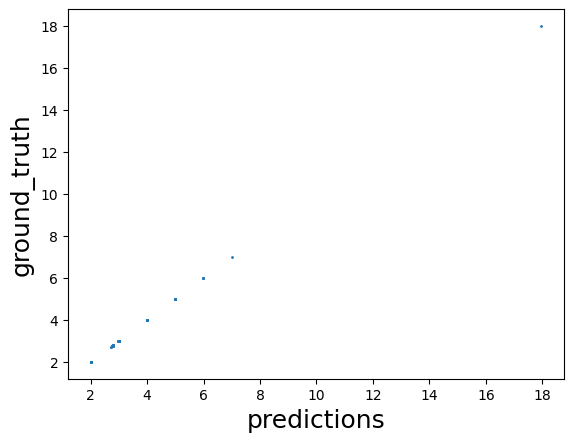

In [42]:
plt.scatter(x=df_result_so2['y_pred'],y=df_result_so2['y_true'],s=1)
plt.xlabel('predictions',fontsize=18)
plt.ylabel('ground_truth',fontsize=18)
plt.show()

## Prediccion proximas 24h

In [44]:
so2_df2=so2.copy()

#dividimos en train, test, val y pred 
so2_train2=so2_df2.iloc[:index] # Para entrenar
so2_test2=so2_df2.iloc[index:index2]  # Para testear
so2_val2=so2_df2.iloc[index2:index3]  # Para evaluar rendimiento
so2_pred2=so2_df2.iloc[index3:] # Para predecir

so2_train2, so2_test2,so2_val2, so2_min_max = normalizacion(train2, test2, val2)

so2_train2.head()


,o3,x_next24,x_lag_1,x_lag_2,x_lag_3,x_lag_4,x_lag_5,x_lag_6,x_lag_7,x_lag_8,...,x_lag_24,x_rmean_24,x_diff1,x_diff24,x_rmean_24f,year,month,dayofweek,hour,date
time_index,,,,,,,,,,,,,,,,,,,,,
2021-10-26 01:00:00,0.468156,0.438259,0.516147,0.57122,0.626293,0.633373,0.655403,0.645175,0.594823,0.535029,...,0.449273,0.457579,0.600227,0.55746,0.393081,0.0,0.818182,0.166667,0.043478,0.0
2021-10-26 02:00:00,0.426458,0.402855,0.468156,0.516147,0.57122,0.626293,0.633373,0.655403,0.645175,0.594823,...,0.391841,0.459773,0.613141,0.574369,0.391584,0.0,0.818182,0.166667,0.086957,0.0
2021-10-26 03:00:00,0.372172,0.375319,0.426458,0.468156,0.516147,0.57122,0.626293,0.633373,0.655403,0.645175,...,0.346996,0.46137,0.587314,0.564224,0.391784,0.0,0.818182,0.166667,0.130435,0.0
2021-10-26 04:00:00,0.354863,0.379253,0.372172,0.426458,0.468156,0.516147,0.57122,0.626293,0.633373,0.655403,...,0.322606,0.463415,0.66318,0.571833,0.39333,0.0,0.818182,0.166667,0.173913,0.0
2021-10-26 05:00:00,0.356437,0.361944,0.354863,0.372172,0.426458,0.468156,0.516147,0.57122,0.626293,0.633373,...,0.313165,0.466158,0.70192,0.583669,0.393679,0.0,0.818182,0.166667,0.217391,0.0


In [45]:
so2_df2=so2.copy()

#dividimos en train, test, val y pred 
so2_train2=so2_df2.iloc[:index] # Para entrenar
so2_test2=so2_df2.iloc[index:index2]  # Para testear
so2_val2=so2_df2.iloc[index2:index3]  # Para evaluar rendimiento
so2_pred2=so2_df2.iloc[index3:] # Para predecir

# Normalizamos los conjuntos
#so2_train2, so2_test2,so2_val2, so2_min_max = normalizacion(train2, test2, val2)
so2_pred2=(so2_pred2-min_max[0])/(min_max[1]-min_max[0])

so2_train2.head(24)

time_index
2021-10-25 01:00:00    5.0
2021-10-25 02:00:00    5.0
2021-10-25 03:00:00    5.0
2021-10-25 04:00:00    5.0
2021-10-25 05:00:00    5.0
2021-10-25 06:00:00    4.0
2021-10-25 07:00:00    5.0
2021-10-25 08:00:00    5.0
2021-10-25 09:00:00    5.0
2021-10-25 10:00:00    5.0
2021-10-25 11:00:00    5.0
2021-10-25 12:00:00    6.0
2021-10-25 13:00:00    6.0
2021-10-25 14:00:00    6.0
2021-10-25 15:00:00    5.0
2021-10-25 16:00:00    5.0
2021-10-25 17:00:00    5.0
2021-10-25 18:00:00    5.0
2021-10-25 19:00:00    5.0
2021-10-25 20:00:00    5.0
2021-10-25 21:00:00    5.0
2021-10-25 22:00:00    5.0
2021-10-25 23:00:00    5.0
2021-10-26 00:00:00    5.0
Name: so2, dtype: float64

In [35]:
so2_df2=so2.copy()

#dividimos en train, test, val y pred 
so2_train2=so2_df2.iloc[:index] # Para entrenar
so2_test2=so2_df2.iloc[index:index2]  # Para testear
so2_val2=so2_df2.iloc[index2:index3]  # Para evaluar rendimiento
so2_pred2=so2_df2.iloc[index3:] # Para predecir

# Normalizamos los conjuntos
so2_train2, so2_test2,so2_val2, so2_min_max = normalizacion(train2, test2, val2)
so2_pred2=(so2_pred2-min_max[0])/(min_max[1]-min_max[0])

#Procesamos
so2_train2=procesamiento2(so2_train2,24)
so2_test2=procesamiento2(so2_test2,24)
so2_val2=procesamiento2(so2_val2,24)
so2_pred2=procesamiento2(so2_pred2,24)

#Dibujamos la division
plt.figure(figsize=(20,10))
plt.plot(so2_train2.index, so2_train2['so2'], label='train')
plt.plot(so2_test2.index, so2_test2['so2'], label='test')
plt.plot(so2_val2.index, so2_val2['so2'], label='validation')
plt.plot(so2_pred2.index, so2_pred2['so2'], label='conjunto_prediccion')
plt.ylabel('so2', fontsize=18)
plt.legend()
plt.show()
       

so2_train2.head(48)

ValueError: Columns must be same length as key

# NO2

### Visualización Clásica (Tendencia, estacionalidad, estacionariedad)

Resample por D:
 time_index
2021-10-25    16.260870
2021-10-26    24.583333
2021-10-27    22.125000
2021-10-28    21.708333
2021-10-29    21.291667
Freq: D, Name: no2, dtype: float64
Media Deslizante (ventana de 720):
 time_index
2021-10-25 01:00:00   NaN
2021-10-25 02:00:00   NaN
2021-10-25 03:00:00   NaN
2021-10-25 04:00:00   NaN
2021-10-25 05:00:00   NaN
2021-10-25 06:00:00   NaN
2021-10-25 07:00:00   NaN
2021-10-25 08:00:00   NaN
2021-10-25 09:00:00   NaN
2021-10-25 10:00:00   NaN
Name: no2, dtype: float64


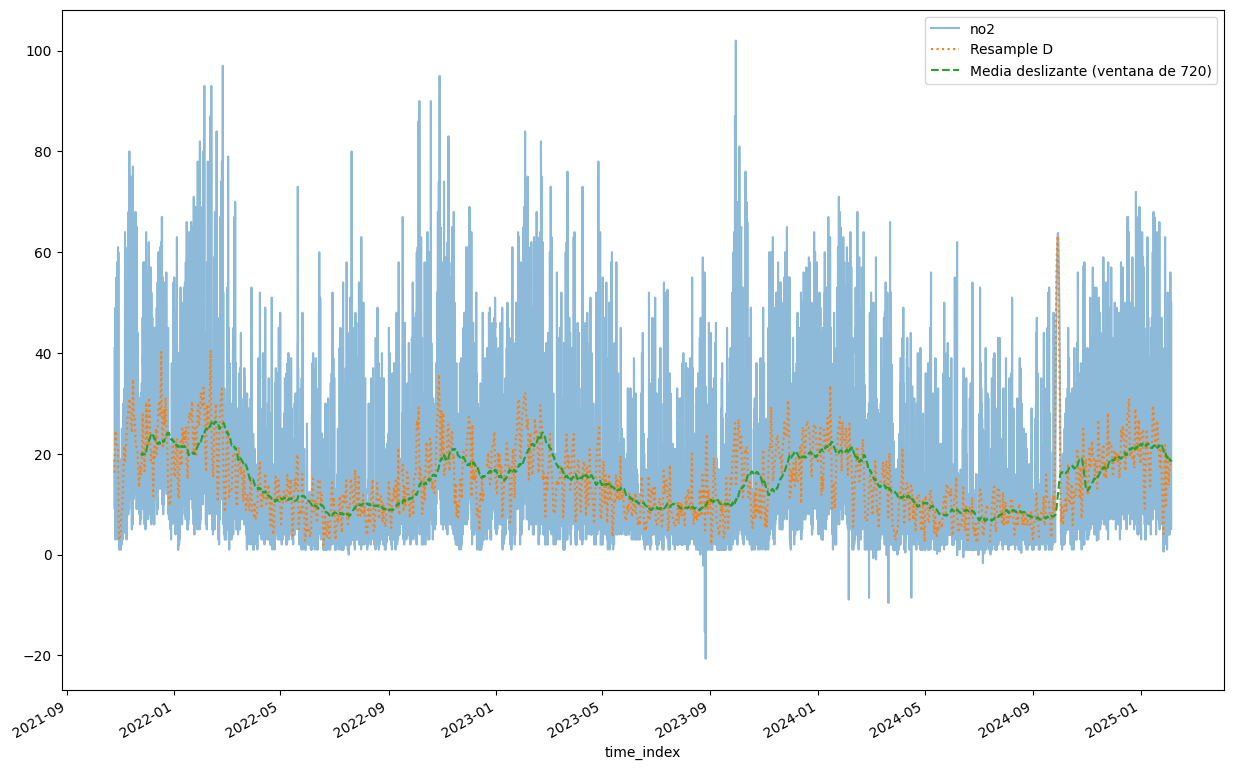

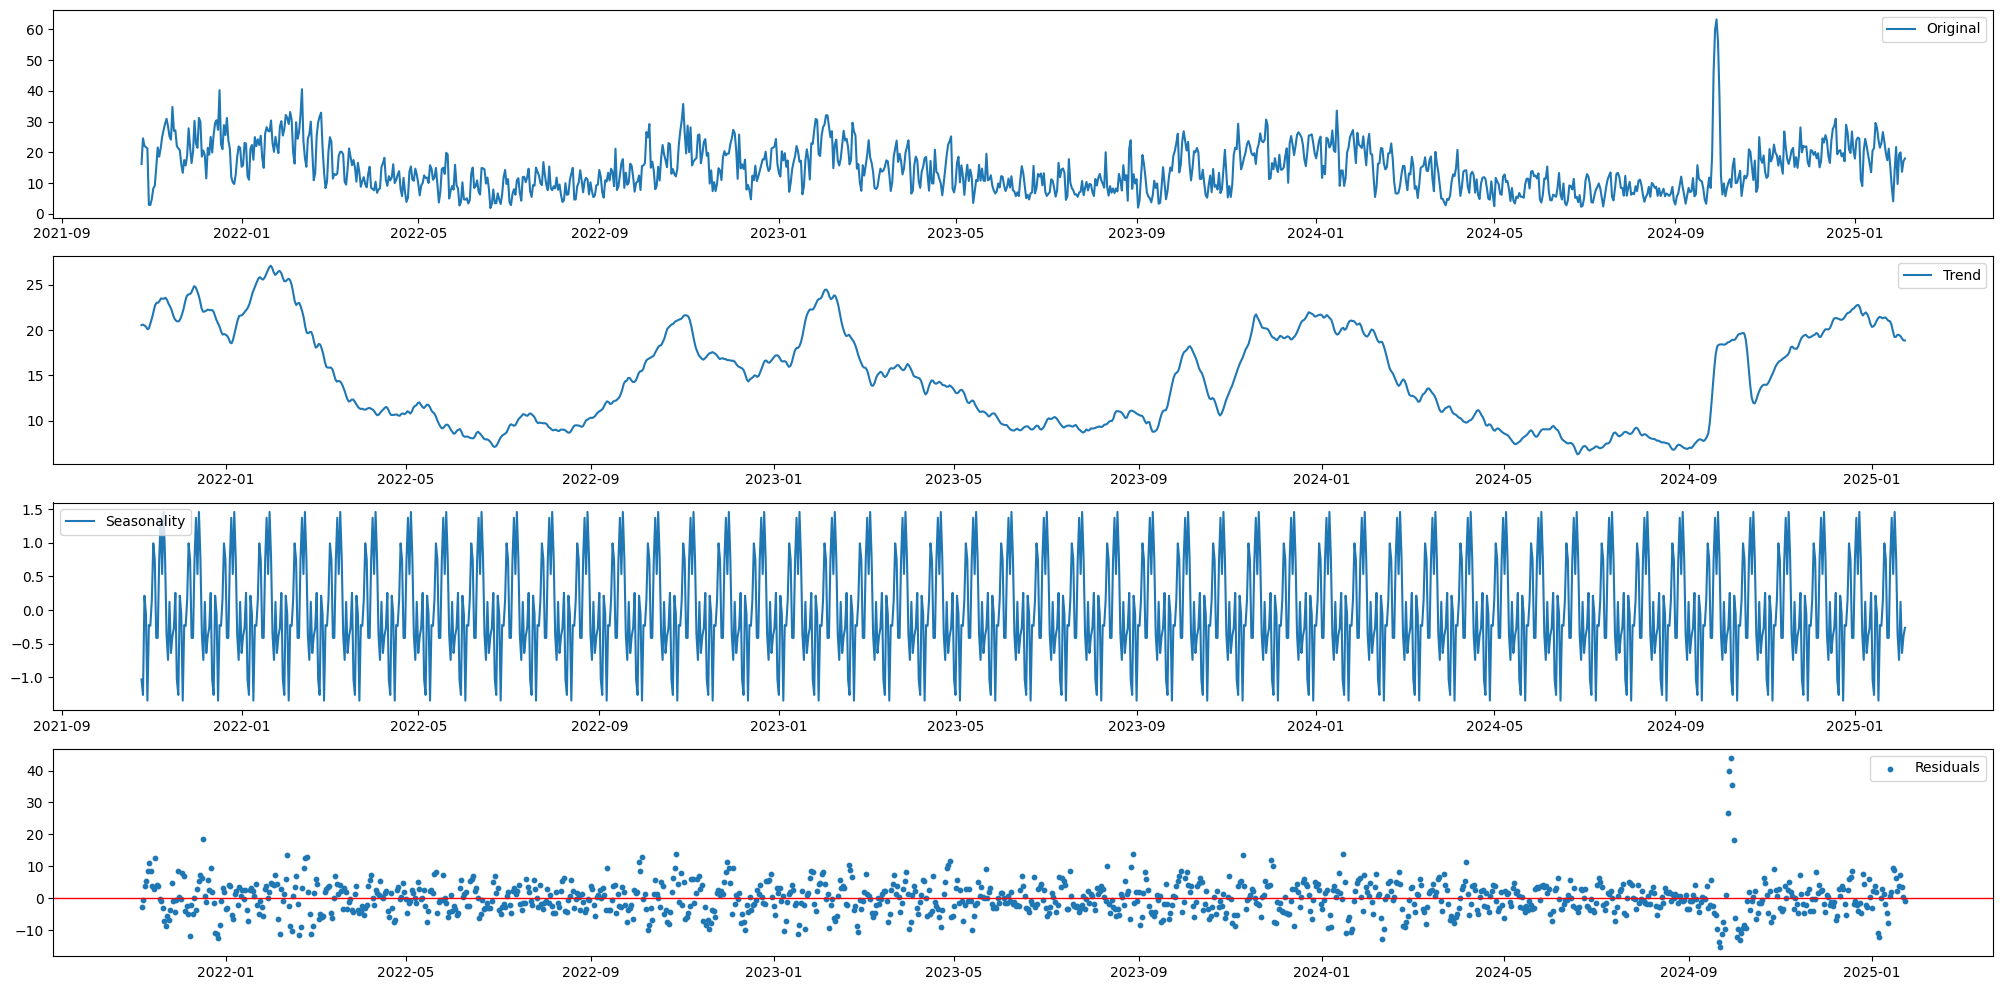

In [43]:
no2=df["no2"]
no2_resample=resample_and_plot(no2)
no2_descomposicion=decompose_and_plot(no2_resample)

## Procesamiento y Modelado

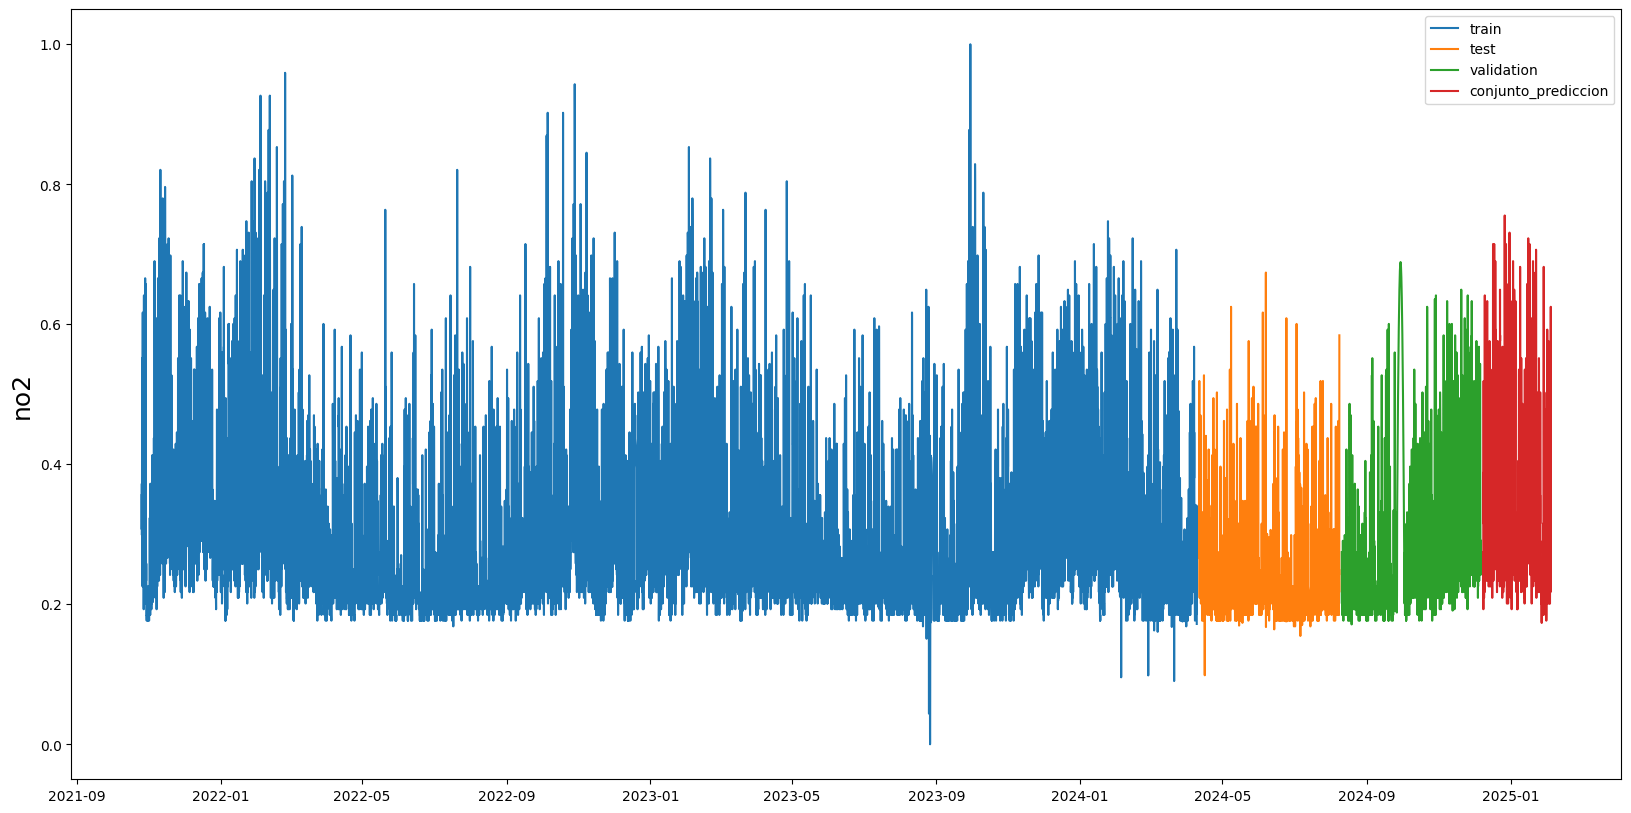

 Estructura DF:


,no2,x_lag_1,x_lag_2,x_lag_3,x_lag_4,x_lag_5,x_rmean_24,x_diff1,x_diff24,x_rmean_24f,year,month,dayofweek,hour,date
time_index,,,,,,,,,,,,,,,
2021-10-26 01:00:00,0.355947,0.429320,0.567914,0.274421,0.559761,0.429320,0.300238,-0.073373,-0.146746,0.375310,2021,10,1,1,2021-10-26
2021-10-26 02:00:00,0.307032,0.355947,0.429320,0.567914,0.274421,0.559761,0.297520,-0.048915,-0.065221,0.375649,2021,10,1,2,2021-10-26
2021-10-26 03:00:00,0.372252,0.307032,0.355947,0.429320,0.567914,0.274421,0.300238,0.065221,0.065221,0.371573,2021,10,1,3,2021-10-26
2021-10-26 04:00:00,0.298879,0.372252,0.307032,0.355947,0.429320,0.567914,0.301936,-0.073373,0.040763,0.370214,2021,10,1,4,2021-10-26
2021-10-26 05:00:00,0.298879,0.298879,0.372252,0.307032,0.355947,0.429320,0.303975,0.000000,0.048915,0.367497,2021,10,1,5,2021-10-26


In [44]:
#division
no2_train=no2.iloc[:index] # Para entrenar
no2_test=no2.iloc[index:index2]  # Para testear
no2_val=no2.iloc[index2:index3]  # Para evaluar rendimiento
no2_prediccion=no2.iloc[index3:] # Para predecir

# Normalizamos los conjuntos
no2_train, no2_test,no2_val, min_max_no2 = normalizacion(no2_train, no2_test, no2_val)
no2_prediccion=(no2_prediccion-min_max_no2[0])/(min_max_no2[1]-min_max_no2[0])

#Procesamos
no2_train=procesamiento(no2_train)
no2_test=procesamiento(no2_test)
no2_val=procesamiento(no2_val)
no2_prediccion=procesamiento(no2_prediccion)

#Dibujamos la division
plt.figure(figsize=(20,10))
plt.plot(no2_train.index, no2_train['no2'], label='train')
plt.plot(no2_test.index, no2_test['no2'], label='test')
plt.plot(no2_val.index, no2_val['no2'], label='validation')
plt.plot(no2_prediccion.index, no2_prediccion['no2'], label='conjunto_prediccion')
plt.ylabel('no2', fontsize=18)
plt.legend()
plt.show()

print("=======\n Estructura DF:")
no2_train.head()

In [45]:
# Modelado

# Convertimos los datos a un objeto H2OFrame
no2_train_h2o = h2o.H2OFrame(no2_train,destination_frame="COCOR_LEPANTO_no2_train")
no2_test_h2o = h2o.H2OFrame(no2_test,destination_frame="COCOR_LEPANTO_no2_test")
no2_val_h2o = h2o.H2OFrame(no2_val,destination_frame="COCOR_LEPANTO_no2_val")
no2_prediccion_h2o = h2o.H2OFrame(no2_prediccion,destination_frame="COCOR_LEPANTO_no2_prediccion")

#Definimos variables dependientes e independientes
x = no2_train_h2o.columns
y = 'no2'
x.remove(y)


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%


In [46]:
# Definimos el Modelo
no2_aml = H2OAutoML(max_runtime_secs = 60,
                seed = 42,
                stopping_metric="deviance",
                sort_metric="RMSE",
                keep_cross_validation_predictions=False, #quitamos validacion cruzada
                nfolds=0, #quitamos validacion cruzada
                project_name="COCOR_LEPANTO_aml_no2",
                stopping_rounds=1,
                stopping_tolerance=1e-4)

#Entrenamos
no2_aml.train(x = x, 
          y = y,
          training_frame = no2_train_h2o,
          leaderboard_frame = no2_test_h2o,
          validation_frame = no2_val_h2o)


AutoML progress: |
13:12:02.970: Stopping tolerance set by the user is < 70% of the recommended default of 0.0068390558377677225, so models may take a long time to converge or may not converge at all.

███████████████████████████████████████████████████████████████| (done) 100%


Model Details
=============
H2OGeneralizedLinearEstimator : Generalized Linear Modeling
Model Key: GLM_1_AutoML_4_20250207_131202


GLM Model: summary
    family    link      regularization               lambda_search                                                                number_of_predictors_total    number_of_active_predictors    number_of_iterations    training_frame
--  --------  --------  ---------------------------  ---------------------------------------------------------------------------  ----------------------------  -----------------------------  ----------------------  ---------------------------------------------------------
    gaussian  identity  Ridge ( lambda = 9.054E-6 )  nlambda = 30, lambda.max = 9.0538, lambda.min = 9.054E-6, lambda.1se = -1.0  14                            14                             30                      AutoML_4_20250207_131202_training_COCOR_LEPANTO_no2_train

ModelMetricsRegressionGLM: glm
** Reported on train data. **

MSE: 3.5670746142406277e-09
RMSE: 5.972499153822148e-05
MAE: 4.3969363305897965e-05
RMSLE: 4.3996905584937405e-05
Mean Residual Deviance: 3.5670746142406277e-09
R^2: 0.9999996919731202
Null degrees of freedom: 21379
Residual degrees of freedom: 21365
Null deviance: 247.5889613863124
Residual deviance: 7.626405525246462e-05
AIC: -355167.6861951755

ModelMetricsRegressionGLM: glm
** Reported on validation data. **

MSE: 2.5665224993187062e-09
RMSE: 5.066085766465769e-05
MAE: 3.750486793327092e-05
RMSLE: 3.754615049427403e-05
Mean Residual Deviance: 2.5665224993187062e-09
R^2: 0.9999997913167709
Null degrees of freedom: 2808
Residual degrees of freedom: 2794
Null deviance: 34.68188462425813
Residual deviance: 7.209361700586245e-06
AIC: -47560.4288549643

Scoring History: 
     timestamp            duration    iteration    lambda    predictors    deviance_train          deviance_test           alpha    iterations    training_rmse          training_deviance       training_mae            training_r2         validation_rmse        validation_deviance     validation_mae         validation_r2
---  -------------------  ----------  -----------  --------  ------------  ----------------------  ----------------------  -------  ------------  ---------------------  ----------------------  ----------------------  ------------------  ---------------------  ----------------------  ---------------------  ------------------
     2025-02-07 13:12:04  0.000 sec   1            .91E1     15            0.00807972062180437     0.007595117115510518    0.0
     2025-02-07 13:12:04  0.001 sec   2            .56E1     15            0.006902817868334898    0.006162707320994348    0.0
     2025-02-07 13:12:04  0.002 sec   3            .35E1     15            0.0056301326122456755   0.004734190388168572    0.0
     2025-02-07 13:12:04  0.003 sec   4            .22E1     15            0.004365416072611551    0.0034449594445192244   0.0
     2025-02-07 13:12:04  0.004 sec   5            .13E1     15            0.003215933048960035    0.002391269142315138    0.0      5             5.972499153822148e-05  3.5670746142406277e-09  4.3969363305897965e-05  0.9999996919731202  5.066085766465769e-05  2.5665224993187062e-09  3.750486793327092e-05  0.9999997913167709
     2025-02-07 13:12:04  0.005 sec   6            .84E0     15            0.0022542436655415554   0.0015949823109923913   0.0
     2025-02-07 13:12:04  0.006 sec   7            .52E0     15            0.0015059849625936317   0.0010268253743064765   0.0
     2025-02-07 13:12:04  0.006 sec   8            .32E0     15            0.0009578079764082652   0.0006369660562830653   0.0
     2025-02-07 13:12:04  0.008 sec   9            .2E0      15            0.0005756630402913264   0.0003765554684563922   0.0
     2025-02-07 13:12:04  0.009 sec   10           .12E0     15            0.0003259321189546982   0.00021085584559827437  0.0
---  ---                  ---         ---          ---       ---           ---                     ---            

In [47]:
# Mostramos el Leaderboard
no2_lb = no2_aml.leaderboard
print("==================\nClasificación de los métodos:\n")
print(no2_lb.head(rows=no2_lb.nrows))

# Evaluar el rendimiento en el conjunto de prediccion
predict_performance = no2_aml.leader.model_performance(no2_prediccion_h2o)
print("====================\nRendimiento en el conjunto de predicción:\n")
print(predict_performance)

print("\n==============\nR² en el conjunto de predicción:", predict_performance.r2())

Clasificación de los métodos:

model_id                                                     rmse          mse          mae        rmsle    mean_residual_deviance
GLM_1_AutoML_4_20250207_131202                        5.01111e-05  2.51112e-09  3.5433e-05   3.85245e-05               2.51112e-09
DeepLearning_1_AutoML_4_20250207_131202               0.0010822    1.17115e-06  0.000911378  0.000876077               1.17115e-06
GBM_grid_1_AutoML_4_20250207_131202_model_8           0.00280334   7.85872e-06  0.000623708  0.00229182                7.85872e-06
GBM_grid_1_AutoML_4_20250207_131202_model_1           0.00333244   1.11051e-05  0.00195047   0.00257353                1.11051e-05
GBM_grid_1_AutoML_4_20250207_131202_model_2           0.00333851   1.11457e-05  0.000872361  0.0027994                 1.11457e-05
XGBoost_grid_1_AutoML_4_20250207_131202_model_3       0.00339      1.14921e-05  0.00127954   0.00270048                1.14921e-05
GBM_2_AutoML_4_20250207_131202                      

In [48]:
#######333
# Predicciones
#################

#realizamos las predicciones
no2_pred=no2_aml.leader.predict(no2_prediccion_h2o)

#Creamos una tabla comparativa y_true vs y_pred
df_result_no2=pd.DataFrame()
df_result_no2["y_true"]=normalizacion_inversa(no2_prediccion['no2'].reset_index(drop=True), min_max_no2[0], min_max_no2[1])
df_result_no2["y_pred"]=normalizacion_inversa(h2o.as_list(no2_pred,use_pandas=True), min_max_no2[0], min_max_no2[1])
df_result_no2.head()



glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/home/p3j0t4/.local/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,y_true,y_pred
0,13.0,13.009841
1,6.0,6.001398
2,6.0,6.011036
3,6.0,6.002293
4,4.0,4.006735


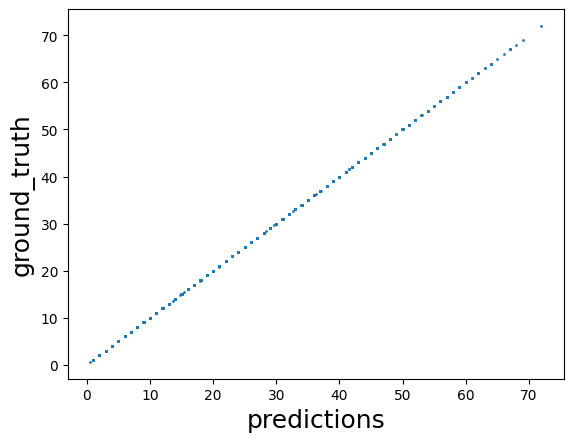

In [49]:
# dibujamos
plt.scatter(x=df_result_no2['y_pred'],y=df_result_no2['y_true'],s=1)
plt.xlabel('predictions',fontsize=18)
plt.ylabel('ground_truth',fontsize=18)
plt.show()

## Prediccion 24h proximas

# PM10 y PM25

In [10]:
h2o.shutdown()

H2O session _sid_bd34 closed.


/tmp/ipykernel_43077/2900054706.py:1: H2ODeprecationWarning: Deprecated, use ``h2o.cluster().shutdown()``.
  h2o.shutdown()


In [11]:
h2o.init()

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O_cluster_uptime:,42 secs
H2O_cluster_timezone:,UTC
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.6
H2O_cluster_version_age:,3 months and 5 days
H2O_cluster_name:,root
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,3.810 Gb
H2O_cluster_total_cores:,12
H2O_cluster_allowed_cores:,12
H2O_cluster_status:,"locked, healthy"
